In [1]:
import os
import socket
import joblib
import numpy as np
import random
from Evaluation import evaluation
from Plotting import plotting as plotting_utils
from Preprocessing import preprocessing
import sys
import seaborn as sns
from tqdm.notebook import tqdm
import pandas as pd
from sklearn import metrics

%pylab inline
%load_ext autoreload
%autoreload 2
print(socket.gethostname())

/usr/local/apps/Anaconda3/2020.11/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.5.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


Populating the interactive namespace from numpy and matplotlib
ift-dgx


/usr/local/apps/Anaconda3/2020.11/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


### Demographics

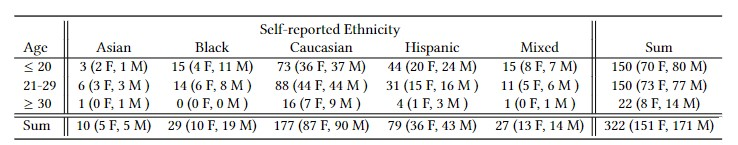

In [36]:
# image from https://arxiv.org/pdf/2009.06171.pdf
from IPython.display import Image
Image(filename='images/demographics.JPG')

In [3]:
Y_columns = {'subId': 0,
 'session': 1,
 'round': 2,
 'trial': 3}

Y_columns_judo = {'subId': 0,
 'session': 1,
 'trialId': 2,
 'seqId': 3,
 'original_trial_length_before_padding': 4}

In [4]:
ethnicity_mapping = {'African':'Black',
                     'African American':'Black',
                     'African-American':'Black',
                     'Asian':'Asian',
                     'Asian/White':'Mixed',
                     'Black':'Black',
                     'Black/Hispanic':'Mixed',
                     'Caucasian':'Caucasian',
                     'Caucasian/Hispanic':'Mixed',
                     'European':'Caucasian',
                     'Hiaspanic/Black/Arab':'Mixed',
                     'Hispanic':'Hispanic',
                     'Hispanic/Caucasian':'Mixed',
                     'Hispanic/Latino':'Hispanic',
                     'Hispanic/Native American':'Mixed',
                     'Hispanic/While':'Mixed',
                     'Hispanic/White':'Mixed',
                     'Latina':'Hispanic',
                     'Lau':'Mixed',
                     'Mexican':'Hispanic',
                     'Mexican American':'Mixed',
                     'Mexican/Hispanic':'Hispanic',
                     'Middle-Eastern':'Mixed', #??
                     'Mixed':'Mixed',
                     'Multiracial':'Mixed',
                     'Native American':'Mixed', #??
                     'West Indian':'Mixed',
                     'White':'Caucasian',
                     'White-Hispanic':'Mixed',
                     'White/Hispanic':'Mixed',
                     'White/Mexican':'Mixed',
                     'White/Mexican American':'Mixed',
                     'Whtie':'Caucasian'}

sex_mapping = {'Female':'Female',
              'Male':'Male',
              'male':'Male'}

In [5]:
age_mapping = {'young_threshold':20,
               'old_threshold': 30}

### Load demographic data

In [6]:
demo_info_df = pd.read_excel('GazeBase_v2_0/GazeBaseDemoInfo.xlsx')

demo_list = ['Age',
             'Self-Identified Gender',
             'Self-Identified Ethnicity',
             'normalized Ethnicity',
             'age_class',
             'normalized Gender']

ethno_list = list(demo_info_df['Self-Identified Ethnicity'])
normalized_ethno_list = []
for i in range(len(ethno_list)):
    normalized_ethno_list.append(ethnicity_mapping[ethno_list[i]])
demo_info_df['normalized Ethnicity'] = list(normalized_ethno_list)

gender_list = list(demo_info_df['Self-Identified Gender'])
normalized_geder_list = []
for i in range(len(ethno_list)):
    normalized_geder_list.append(sex_mapping[gender_list[i]])
demo_info_df['normalized Gender'] = list(normalized_geder_list)

age_list = []
age = list(demo_info_df['Age'])
for i in range(len(age)):
    cur_class = 'between'
    if age[i] <= age_mapping['young_threshold']:
        cur_class = 'younger'
    if age[i] >= age_mapping['old_threshold']:
        cur_class = 'older'
    age_list.append(cur_class)
demo_info_df['age_class'] = list(age_list)

demo_dict = dict()
for i in range(len(demo_info_df)):
    cur_line = demo_info_df.iloc[i]
    cur_part = cur_line['Participant ID']
    for demo_type in demo_list:
        if demo_type not in demo_dict:
            demo_dict[demo_type] = dict()
        demo_dict[demo_type][cur_part] = cur_line[demo_type]

In [7]:
demo_info_df.head()

Participant ID  Age Self-Identified Gender Self-Identified Ethnicity  \
0               1   30                   Male                  Hispanic   
1               2   18                   Male                     White   
2               3   19                   Male                     Mixed   
3               4   19                 Female                  Hispanic   
4               5   22                   Male                     White   

  normalized Ethnicity normalized Gender age_class  
0             Hispanic              Male     older  
1            Caucasian              Male   younger  
2                Mixed              Male   younger  
3             Hispanic            Female   younger  
4            Caucasian              Male   between

In [8]:
age_groups = list(np.unique(list(demo_info_df['age_class'])))
age_groups = ['younger','between','older']
print(age_groups)

['younger', 'between', 'older']


In [9]:
n_ethno = list(np.unique(list(demo_info_df['normalized Ethnicity'])))
print(n_ethno)

['Asian', 'Black', 'Caucasian', 'Hispanic', 'Mixed']


In [10]:
n_gender = list(np.unique(list(demo_info_df['normalized Gender'])))
print(n_gender)

['Female', 'Male']


In [11]:
age_list = np.array(demo_info_df['age_class'])
et_list = np.array(demo_info_df['normalized Ethnicity'])
gender_list = np.array(demo_info_df['normalized Gender'])
for age in age_groups:
    cur_line_str = ''
    for et in n_ethno:
        cur_et_str = ' ('
        total_sum = 0
        for ge in n_gender:
            cur_idx = np.logical_and(
                    np.logical_and(np.isin(age_list,age),
                                  np.isin(et_list,et)),
                                    np.isin(gender_list,ge))
            cur_num = np.sum(cur_idx)
            total_sum += cur_num
            cur_et_str += str(cur_num) + ' ' + ge[0] + ' '
        cur_et_str = str(total_sum) + cur_et_str + ')'
        cur_et_str = cur_et_str.replace('F','F,')
        cur_line_str += ' & ' + cur_et_str
    print(cur_line_str)

 & 3 (2 F, 1 M ) & 15 (4 F, 11 M ) & 73 (36 F, 37 M ) & 44 (20 F, 24 M ) & 15 (8 F, 7 M )
 & 6 (3 F, 3 M ) & 14 (6 F, 8 M ) & 88 (44 F, 44 M ) & 31 (15 F, 16 M ) & 11 (5 F, 6 M )
 & 1 (0 F, 1 M ) & 0 (0 F, 0 M ) & 16 (7 F, 9 M ) & 4 (1 F, 3 M ) & 1 (0 F, 1 M )


# Plot results

In [17]:
session_key = 'session'
seq_id_key = 'round'
load_dir = 'saved_embeddings/'
model_name = 'deep_eye'
num_sessions = 2

use_trial_type_list = [['TEX'],
                       ['BLG'],
                       ['FXS'],
                       ['HSS'],
                       ['RAN'],
                       ['VD1,VD2']]
inspect_thresholds = [0.1,0.01,0.001]
table_thresholds = [0.1,0.01]
plot_save_dir = 'plots/'

## Ethnicity on test set with randomly sampled persons (100)

In [18]:
ethnicity_metric_dict = dict()
ethnicity_fdr_metric_dict = dict()
ethnicity_fdr_dict = dict()
for use_trial_types in tqdm(use_trial_type_list):
    trial_str = str(use_trial_types)
    metric_dict = plotting_utils.get_metric_dict_for_setting(inspect_key = 'normalized Ethnicity',
                            inspect_list = ['Caucasian','Black','Asian','Hispanic'],
                            window_size =  10,
                            num_folds = 10,
                            use_trial_types = use_trial_types,
                            used_train_key = 'random',
                            used_train_percentage = '1',
                            used_train_seconds_per_user = 80,
                            data_dir = 'saved_score_dicts/',
                            demo_dict = demo_dict)
    if len(metric_dict) > 0:
        ethnicity_metric_dict[trial_str] = metric_dict
        fdr_metric_dict, fdr_dict = plotting_utils.get_fdr_metric_dict(metric_dict,
                            inspect_thresholds = inspect_thresholds,
                            plot_points = 5000)
        ethnicity_fdr_metric_dict[trial_str] = fdr_metric_dict
        ethnicity_fdr_dict[trial_str] = fdr_dict

100%|██████████| 10/10 [03:09<00:00, 18.95s/it]

['TEX']


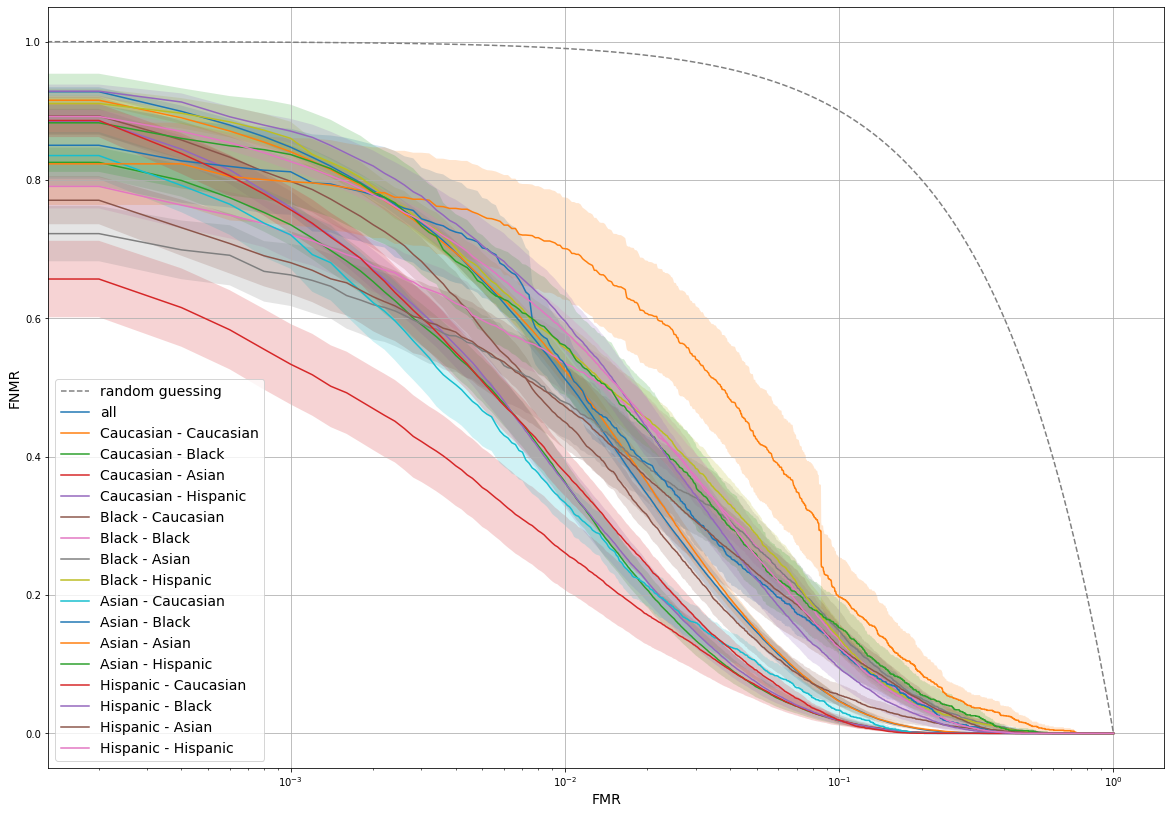

\begin{tabular}{l||rr|rr||c||c} 
\toprule 
$	\tau = FMR_{10^x}$ & $10^{-1}$ & $10^{-2}$ & $10^{-1}$ & $10^{-2}$ &  & \\ \hline 
Demographics  (e-p)& \multicolumn{2}{c|}{$FMR_x(\tau)$}& \multicolumn{2}{c||}{$FNMR_x(\tau)$}& $EER$ & $ROC_{AUC}$ \\ \hline 

Caucasian - Caucasian & 0.113 $ \pm$ 0.009 & 0.013 $ \pm$ 0.002 & 0.04 $ \pm$ 0.009 & 0.483 $ \pm$ 0.03 & 0.077 $ \pm$ 0.003 & 0.975 $ \pm$ 0.002\\
Caucasian - Black & 0.067 $ \pm$ 0.002 & 0.006 $ \pm$ 0.001 & 0.04 $ \pm$ 0.009 & 0.483 $ \pm$ 0.03 & 0.054 $ \pm$ 0.004 & 0.986 $ \pm$ 0.002\\
Caucasian - Asian & 0.061 $ \pm$ 0.006 & 0.003 $ \pm$ 0.001 & 0.04 $ \pm$ 0.009 & 0.476 $ \pm$ 0.031 & 0.051 $ \pm$ 0.006 & 0.988 $ \pm$ 0.003\\
Caucasian - Hispanic & 0.069 $ \pm$ 0.001 & 0.006 $ \pm$ 0.0 & 0.04 $ \pm$ 0.009 & 0.483 $ \pm$ 0.03 & 0.056 $ \pm$ 0.004 & 0.985 $ \pm$ 0.002\\
Black - Caucasian & 0.071 $ \pm$ 0.004 & 0.004 $ \pm$ 0.001 & 0.087 $ \pm$ 0.015 & 0.623 $ \pm$ 0.021 & 0.076 $ \pm$ 0.007 & 0.975 $ \pm$ 0.004\\
Black - Black & 0

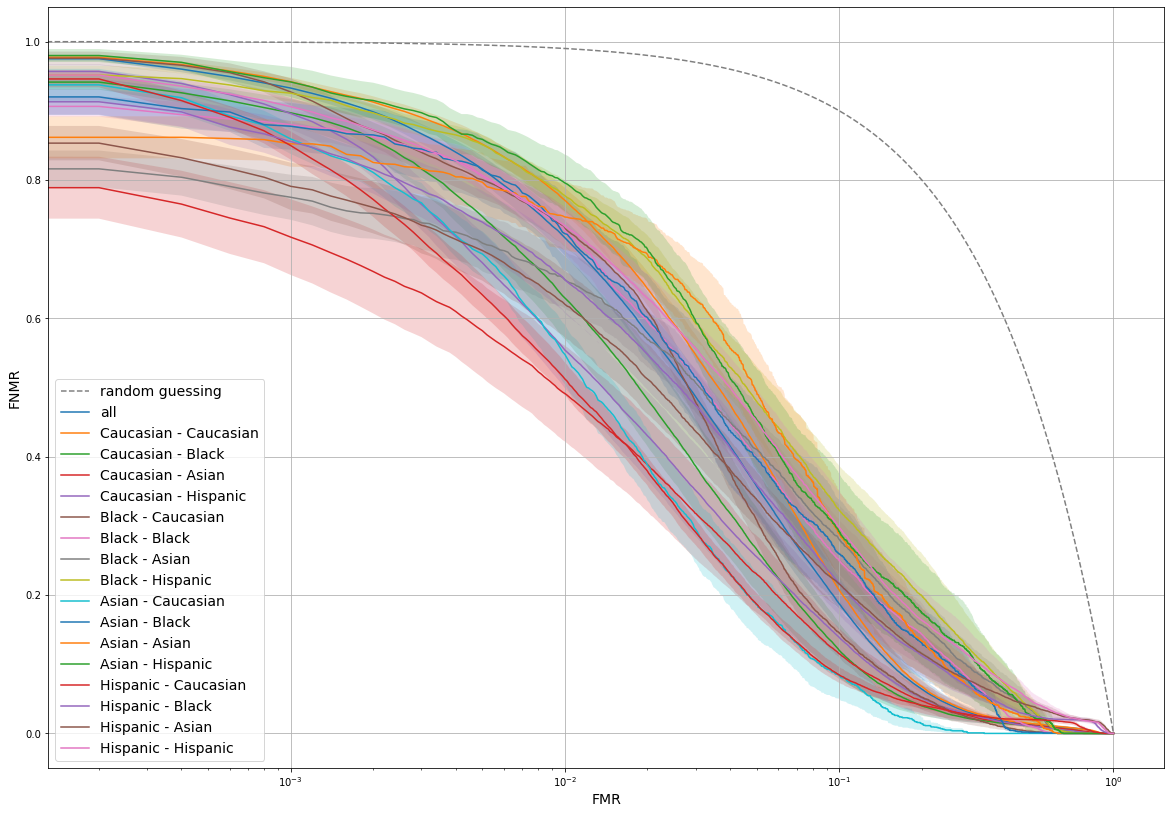

\begin{tabular}{l||rr|rr||c||c} 
\toprule 
$	\tau = FMR_{10^x}$ & $10^{-1}$ & $10^{-2}$ & $10^{-1}$ & $10^{-2}$ &  & \\ \hline 
Demographics  (e-p)& \multicolumn{2}{c|}{$FMR_x(\tau)$}& \multicolumn{2}{c||}{$FNMR_x(\tau)$}& $EER$ & $ROC_{AUC}$ \\ \hline 

Caucasian - Caucasian & 0.125 $ \pm$ 0.012 & 0.017 $ \pm$ 0.002 & 0.189 $ \pm$ 0.05 & 0.685 $ \pm$ 0.039 & 0.134 $ \pm$ 0.006 & 0.93 $ \pm$ 0.005\\
Caucasian - Black & 0.068 $ \pm$ 0.004 & 0.009 $ \pm$ 0.002 & 0.189 $ \pm$ 0.05 & 0.685 $ \pm$ 0.039 & 0.098 $ \pm$ 0.012 & 0.952 $ \pm$ 0.009\\
Caucasian - Asian & 0.06 $ \pm$ 0.008 & 0.006 $ \pm$ 0.003 & 0.189 $ \pm$ 0.05 & 0.686 $ \pm$ 0.039 & 0.097 $ \pm$ 0.014 & 0.956 $ \pm$ 0.01\\
Caucasian - Hispanic & 0.07 $ \pm$ 0.004 & 0.005 $ \pm$ 0.0 & 0.189 $ \pm$ 0.05 & 0.685 $ \pm$ 0.039 & 0.102 $ \pm$ 0.015 & 0.951 $ \pm$ 0.012\\
Black - Caucasian & 0.064 $ \pm$ 0.005 & 0.007 $ \pm$ 0.001 & 0.25 $ \pm$ 0.037 & 0.793 $ \pm$ 0.022 & 0.116 $ \pm$ 0.013 & 0.947 $ \pm$ 0.007\\
Black - Black & 0.1

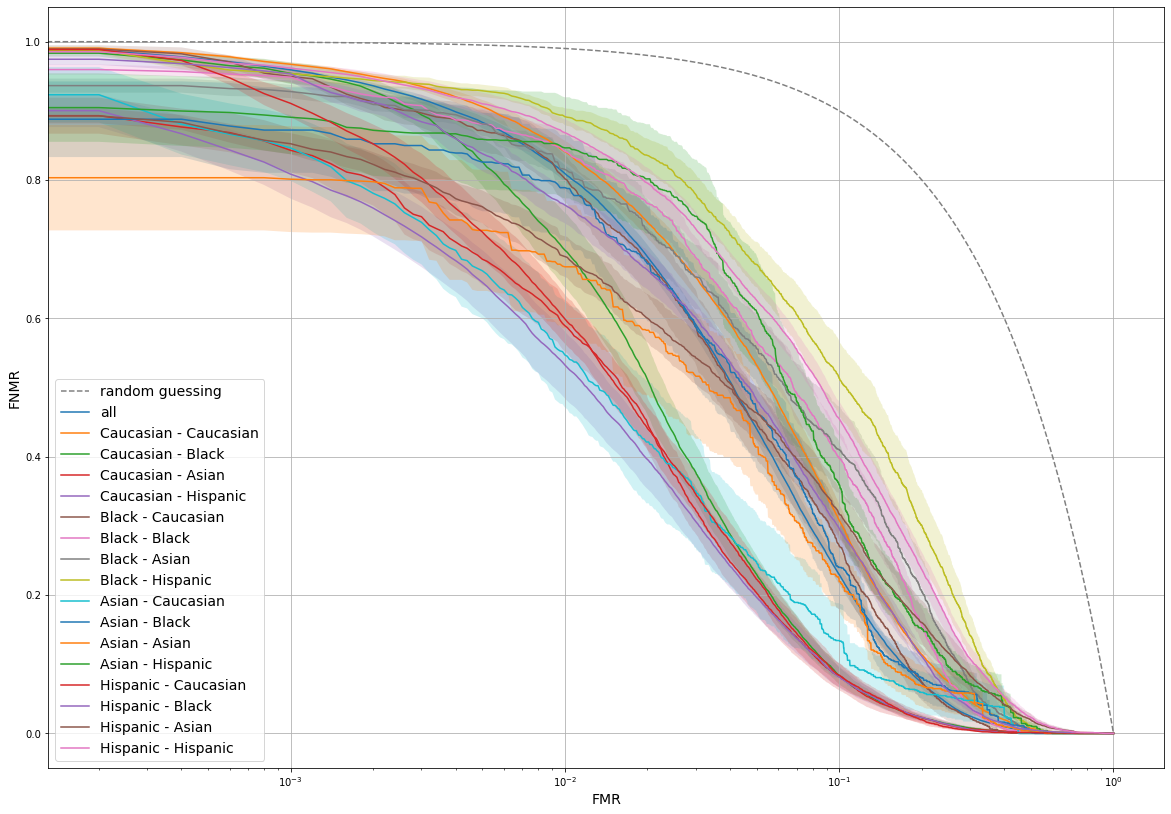

\begin{tabular}{l||rr|rr||c||c} 
\toprule 
$	\tau = FMR_{10^x}$ & $10^{-1}$ & $10^{-2}$ & $10^{-1}$ & $10^{-2}$ &  & \\ \hline 
Demographics  (e-p)& \multicolumn{2}{c|}{$FMR_x(\tau)$}& \multicolumn{2}{c||}{$FNMR_x(\tau)$}& $EER$ & $ROC_{AUC}$ \\ \hline 

Caucasian - Caucasian & 0.138 $ \pm$ 0.011 & 0.017 $ \pm$ 0.003 & 0.208 $ \pm$ 0.016 & 0.793 $ \pm$ 0.018 & 0.162 $ \pm$ 0.005 & 0.912 $ \pm$ 0.004\\
Caucasian - Black & 0.053 $ \pm$ 0.003 & 0.008 $ \pm$ 0.001 & 0.208 $ \pm$ 0.016 & 0.793 $ \pm$ 0.018 & 0.092 $ \pm$ 0.005 & 0.961 $ \pm$ 0.004\\
Caucasian - Asian & 0.05 $ \pm$ 0.008 & 0.002 $ \pm$ 0.001 & 0.207 $ \pm$ 0.016 & 0.794 $ \pm$ 0.017 & 0.09 $ \pm$ 0.007 & 0.966 $ \pm$ 0.005\\
Caucasian - Hispanic & 0.046 $ \pm$ 0.004 & 0.002 $ \pm$ 0.001 & 0.208 $ \pm$ 0.016 & 0.793 $ \pm$ 0.018 & 0.091 $ \pm$ 0.007 & 0.967 $ \pm$ 0.004\\
Black - Caucasian & 0.059 $ \pm$ 0.005 & 0.005 $ \pm$ 0.001 & 0.425 $ \pm$ 0.037 & 0.887 $ \pm$ 0.024 & 0.148 $ \pm$ 0.013 & 0.929 $ \pm$ 0.009\\
Black - Bl

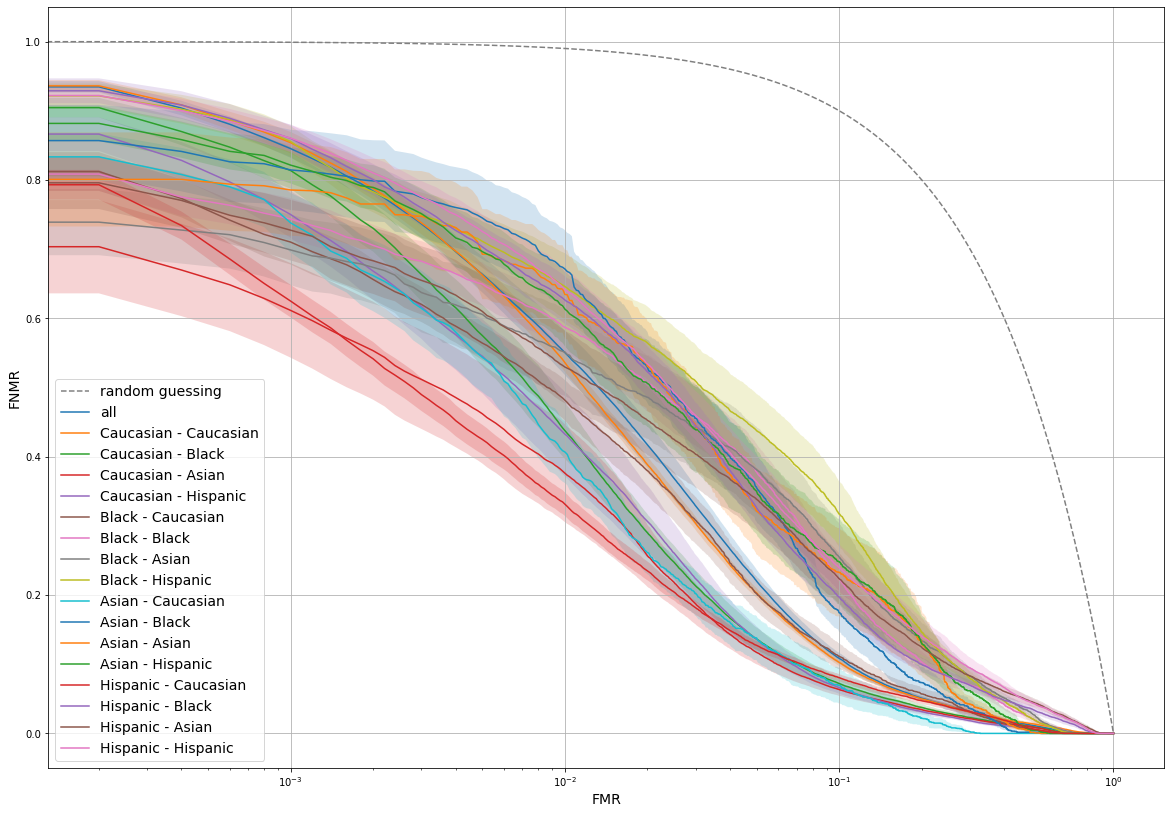

\begin{tabular}{l||rr|rr||c||c} 
\toprule 
$	\tau = FMR_{10^x}$ & $10^{-1}$ & $10^{-2}$ & $10^{-1}$ & $10^{-2}$ &  & \\ \hline 
Demographics  (e-p)& \multicolumn{2}{c|}{$FMR_x(\tau)$}& \multicolumn{2}{c||}{$FNMR_x(\tau)$}& $EER$ & $ROC_{AUC}$ \\ \hline 

Caucasian - Caucasian & 0.106 $ \pm$ 0.01 & 0.011 $ \pm$ 0.002 & 0.103 $ \pm$ 0.011 & 0.564 $ \pm$ 0.05 & 0.102 $ \pm$ 0.002 & 0.956 $ \pm$ 0.002\\
Caucasian - Black & 0.069 $ \pm$ 0.005 & 0.006 $ \pm$ 0.001 & 0.103 $ \pm$ 0.011 & 0.564 $ \pm$ 0.05 & 0.083 $ \pm$ 0.006 & 0.968 $ \pm$ 0.003\\
Caucasian - Asian & 0.056 $ \pm$ 0.007 & 0.004 $ \pm$ 0.002 & 0.103 $ \pm$ 0.011 & 0.558 $ \pm$ 0.05 & 0.075 $ \pm$ 0.007 & 0.972 $ \pm$ 0.004\\
Caucasian - Hispanic & 0.063 $ \pm$ 0.003 & 0.005 $ \pm$ 0.0 & 0.103 $ \pm$ 0.011 & 0.564 $ \pm$ 0.05 & 0.079 $ \pm$ 0.006 & 0.97 $ \pm$ 0.003\\
Black - Caucasian & 0.059 $ \pm$ 0.004 & 0.003 $ \pm$ 0.001 & 0.193 $ \pm$ 0.029 & 0.595 $ \pm$ 0.027 & 0.103 $ \pm$ 0.008 & 0.958 $ \pm$ 0.004\\
Black - Black & 

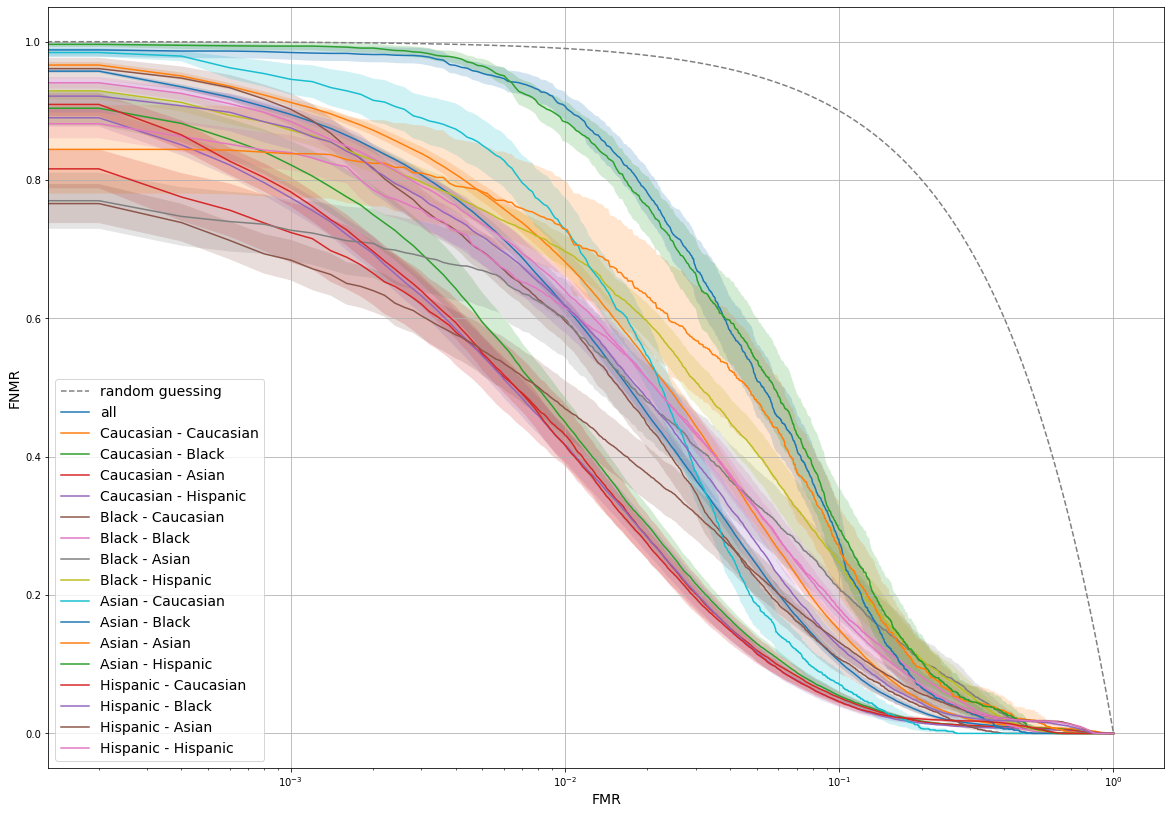

\begin{tabular}{l||rr|rr||c||c} 
\toprule 
$	\tau = FMR_{10^x}$ & $10^{-1}$ & $10^{-2}$ & $10^{-1}$ & $10^{-2}$ &  & \\ \hline 
Demographics  (e-p)& \multicolumn{2}{c|}{$FMR_x(\tau)$}& \multicolumn{2}{c||}{$FNMR_x(\tau)$}& $EER$ & $ROC_{AUC}$ \\ \hline 

Caucasian - Caucasian & 0.139 $ \pm$ 0.008 & 0.017 $ \pm$ 0.002 & 0.095 $ \pm$ 0.01 & 0.581 $ \pm$ 0.018 & 0.118 $ \pm$ 0.004 & 0.946 $ \pm$ 0.003\\
Caucasian - Black & 0.066 $ \pm$ 0.004 & 0.006 $ \pm$ 0.001 & 0.095 $ \pm$ 0.01 & 0.58 $ \pm$ 0.018 & 0.076 $ \pm$ 0.004 & 0.972 $ \pm$ 0.003\\
Caucasian - Asian & 0.058 $ \pm$ 0.007 & 0.006 $ \pm$ 0.001 & 0.095 $ \pm$ 0.01 & 0.579 $ \pm$ 0.018 & 0.073 $ \pm$ 0.006 & 0.974 $ \pm$ 0.003\\
Caucasian - Hispanic & 0.059 $ \pm$ 0.002 & 0.004 $ \pm$ 0.0 & 0.095 $ \pm$ 0.01 & 0.581 $ \pm$ 0.018 & 0.072 $ \pm$ 0.004 & 0.975 $ \pm$ 0.002\\
Black - Caucasian & 0.057 $ \pm$ 0.002 & 0.004 $ \pm$ 0.001 & 0.195 $ \pm$ 0.027 & 0.724 $ \pm$ 0.022 & 0.102 $ \pm$ 0.009 & 0.961 $ \pm$ 0.005\\
Black - Black &

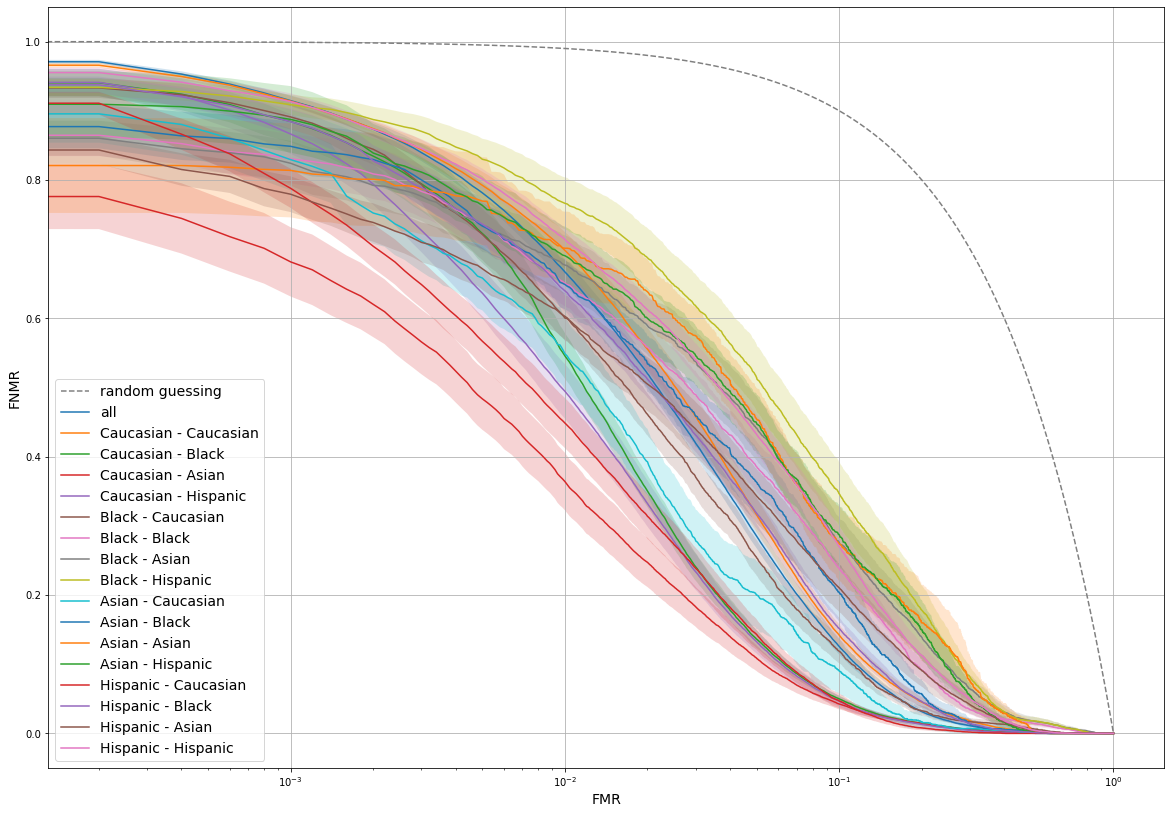

\begin{tabular}{l||rr|rr||c||c} 
\toprule 
$	\tau = FMR_{10^x}$ & $10^{-1}$ & $10^{-2}$ & $10^{-1}$ & $10^{-2}$ &  & \\ \hline 
Demographics  (e-p)& \multicolumn{2}{c|}{$FMR_x(\tau)$}& \multicolumn{2}{c||}{$FNMR_x(\tau)$}& $EER$ & $ROC_{AUC}$ \\ \hline 

Caucasian - Caucasian & 0.126 $ \pm$ 0.01 & 0.015 $ \pm$ 0.002 & 0.105 $ \pm$ 0.01 & 0.653 $ \pm$ 0.027 & 0.115 $ \pm$ 0.005 & 0.949 $ \pm$ 0.004\\
Caucasian - Black & 0.061 $ \pm$ 0.003 & 0.007 $ \pm$ 0.001 & 0.105 $ \pm$ 0.01 & 0.652 $ \pm$ 0.027 & 0.075 $ \pm$ 0.003 & 0.974 $ \pm$ 0.002\\
Caucasian - Asian & 0.051 $ \pm$ 0.007 & 0.002 $ \pm$ 0.001 & 0.105 $ \pm$ 0.01 & 0.652 $ \pm$ 0.026 & 0.069 $ \pm$ 0.005 & 0.98 $ \pm$ 0.003\\
Caucasian - Hispanic & 0.059 $ \pm$ 0.002 & 0.005 $ \pm$ 0.001 & 0.105 $ \pm$ 0.01 & 0.653 $ \pm$ 0.027 & 0.074 $ \pm$ 0.004 & 0.975 $ \pm$ 0.002\\
Black - Caucasian & 0.052 $ \pm$ 0.003 & 0.004 $ \pm$ 0.001 & 0.245 $ \pm$ 0.027 & 0.777 $ \pm$ 0.019 & 0.103 $ \pm$ 0.005 & 0.957 $ \pm$ 0.004\\
Black - Black 

In [19]:
for use_trial_types in tqdm(use_trial_type_list):
    trial_str = str(use_trial_types)
    print(trial_str)
    counter = 0
    if trial_str not in ethnicity_metric_dict:
        continue
    plt.figure(figsize = (20,14))
    for legend_key in ethnicity_metric_dict[trial_str]:
        if counter == 0:
            plot_random = True
        else:
            plot_random = False
        plotting_utils.avg_fnr_fpr_curve(ethnicity_metric_dict[trial_str][legend_key]['fprs'],
                    ethnicity_metric_dict[trial_str][legend_key]['tprs'], 
                    label = legend_key, plot_random=plot_random,
                    title = None, plot_statistics = False,
                    loc = 'best', plot_legend = True,
                    plot_points = 5000, ncol=1,
                    bbox_to_anchor=None,
                    starting_point = None,
                    fontsize = 14, xscale = 'log',
                    setting = 'verification')
        counter += 1
    plt.savefig(plot_save_dir + 'det_curve_ethnicity_' + trial_str + '.pdf')
    plt.show()   
    plotting_utils.print_fmr_fnmr_table(ethnicity_metric_dict[trial_str],
                                   ethnicity_fdr_metric_dict[trial_str],
                                   ethnicity_fdr_dict[trial_str],
                                   inspect_thresholds = table_thresholds,
                                   decimals=3,
                                   print_eer = True,
                                   print_fdr = False,
                                   print_roc_auc = True,
                                   compare_key = 'Caucasian - Caucasian')    

In [20]:
fdr_aucs_all = plotting_utils.print_fdr_table(ethnicity_metric_dict,
                    ethnicity_fdr_metric_dict,
                    ethnicity_fdr_dict,
                    inspect_thresholds = [0.1,0.01,0.001],
                    use_trial_type_list = [['TEX'],
                       ['BLG'],
                       ['FXS'],
                       ['HSS'],
                       ['RAN'],
                       ['VD1,VD2']],
                    decimals = 2,
                    plot_intersectedAUC= False,
                    plot_fdrAUC = True,
                    fdr_thresholds = [0.1,0.05,0.01,0.005,0.001],
                    fdr_alpha = 0.5)

\begin{tabular}{l||rrr||r}
\toprule 
$	\tau = FMR_{10^x}$ & $10^{-1}$ & $10^{-2}$ & $10^{-3}$ & \\ \hline 
 Task& \multicolumn{3}{c||}{$FDR(\tau)$} & $FDR_{AUC}$ \\ \hline
'TEX' & 0.89 $ \pm$ 0.02 & 0.86 $ \pm$ 0.01 & 0.9 $ \pm$ 0.01 & 0.87 $ \pm$ 0.01\\
'BLG' & 0.84 $ \pm$ 0.02 & 0.87 $ \pm$ 0.02 & 0.95 $ \pm$ 0.01 & 0.85 $ \pm$ 0.02\\
'FXS' & 0.78 $ \pm$ 0.02 & 0.86 $ \pm$ 0.02 & 0.97 $ \pm$ 0.0 & 0.81 $ \pm$ 0.02\\
'HSS' & 0.83 $ \pm$ 0.02 & 0.84 $ \pm$ 0.02 & 0.9 $ \pm$ 0.01 & 0.84 $ \pm$ 0.01\\
'RAN' & 0.86 $ \pm$ 0.01 & 0.8 $ \pm$ 0.01 & 0.93 $ \pm$ 0.0 & 0.81 $ \pm$ 0.01\\
'VD1,VD2' & 0.82 $ \pm$ 0.02 & 0.86 $ \pm$ 0.01 & 0.92 $ \pm$ 0.01 & 0.83 $ \pm$ 0.01\\
\bottomrule
\end{tabular}


## Gender on test set with randomly sampled persons (100)

In [24]:
gender_metric_dict = dict()
gender_fdr_metric_dict = dict()
gender_fdr_dict = dict()
for use_trial_types in tqdm(use_trial_type_list):
    trial_str = str(use_trial_types)
    metric_dict = plotting_utils.get_metric_dict_for_setting(inspect_key = 'Self-Identified Gender',
                            inspect_list = ['Male','Female'],
                            window_size =  10,
                            num_folds = 10,
                            use_trial_types = use_trial_types,
                            used_train_key = 'random',
                            used_train_percentage = '1',
                            used_train_seconds_per_user = 80,
                            data_dir = 'saved_score_dicts/',
                            demo_dict = demo_dict)
    if len(metric_dict) > 0:
        gender_metric_dict[trial_str] = metric_dict
        fdr_metric_dict, fdr_dict = plotting_utils.get_fdr_metric_dict(metric_dict,
                            inspect_thresholds = inspect_thresholds,
                            plot_points = 5000)
        gender_fdr_metric_dict[trial_str] = fdr_metric_dict
        gender_fdr_dict[trial_str] = fdr_dict

100%|██████████| 10/10 [02:30<00:00, 15.05s/it]

['TEX']


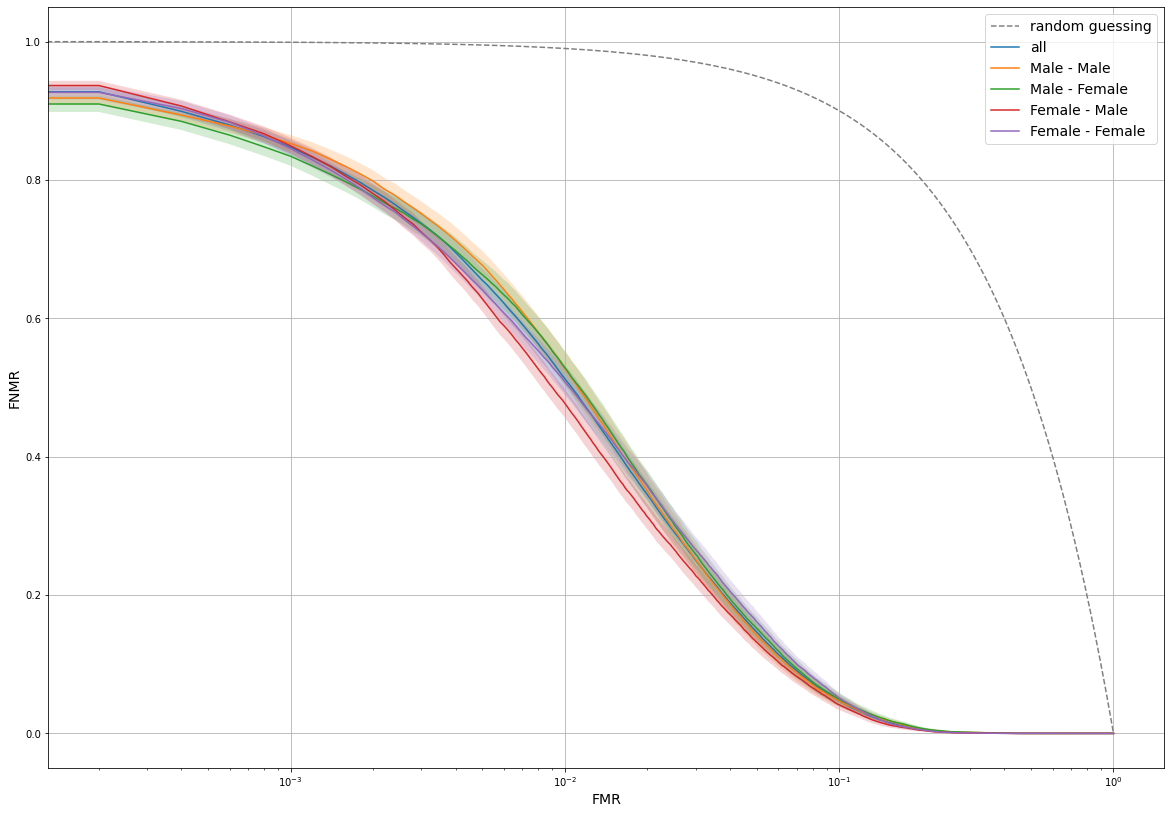

\begin{tabular}{l||rr|rr||c||c} 
\toprule 
$	\tau = FMR_{10^x}$ & $10^{-1}$ & $10^{-2}$ & $10^{-1}$ & $10^{-2}$ &  & \\ \hline 
Demographics  (e-p)& \multicolumn{2}{c|}{$FMR_x(\tau)$}& \multicolumn{2}{c||}{$FNMR_x(\tau)$}& $EER$ & $ROC_{AUC}$ \\ \hline 

Male - Male & 0.097 $ \pm$ 0.001 & 0.01 $ \pm$ 0.001 & 0.049 $ \pm$ 0.009 & 0.53 $ \pm$ 0.021 & 0.076 $ \pm$ 0.004 & 0.975 $ \pm$ 0.002\\
Male - Female & 0.1 $ \pm$ 0.001 & 0.01 $ \pm$ 0.0 & 0.049 $ \pm$ 0.009 & 0.53 $ \pm$ 0.021 & 0.077 $ \pm$ 0.004 & 0.975 $ \pm$ 0.002\\
Female - Male & 0.097 $ \pm$ 0.001 & 0.009 $ \pm$ 0.0 & 0.045 $ \pm$ 0.008 & 0.493 $ \pm$ 0.02 & 0.074 $ \pm$ 0.004 & 0.978 $ \pm$ 0.002\\
Female - Female & 0.107 $ \pm$ 0.001 & 0.011 $ \pm$ 0.0 & 0.045 $ \pm$ 0.008 & 0.493 $ \pm$ 0.02 & 0.08 $ \pm$ 0.004 & 0.975 $ \pm$ 0.002\\
\bottomrule
\end{tabular}
['BLG']


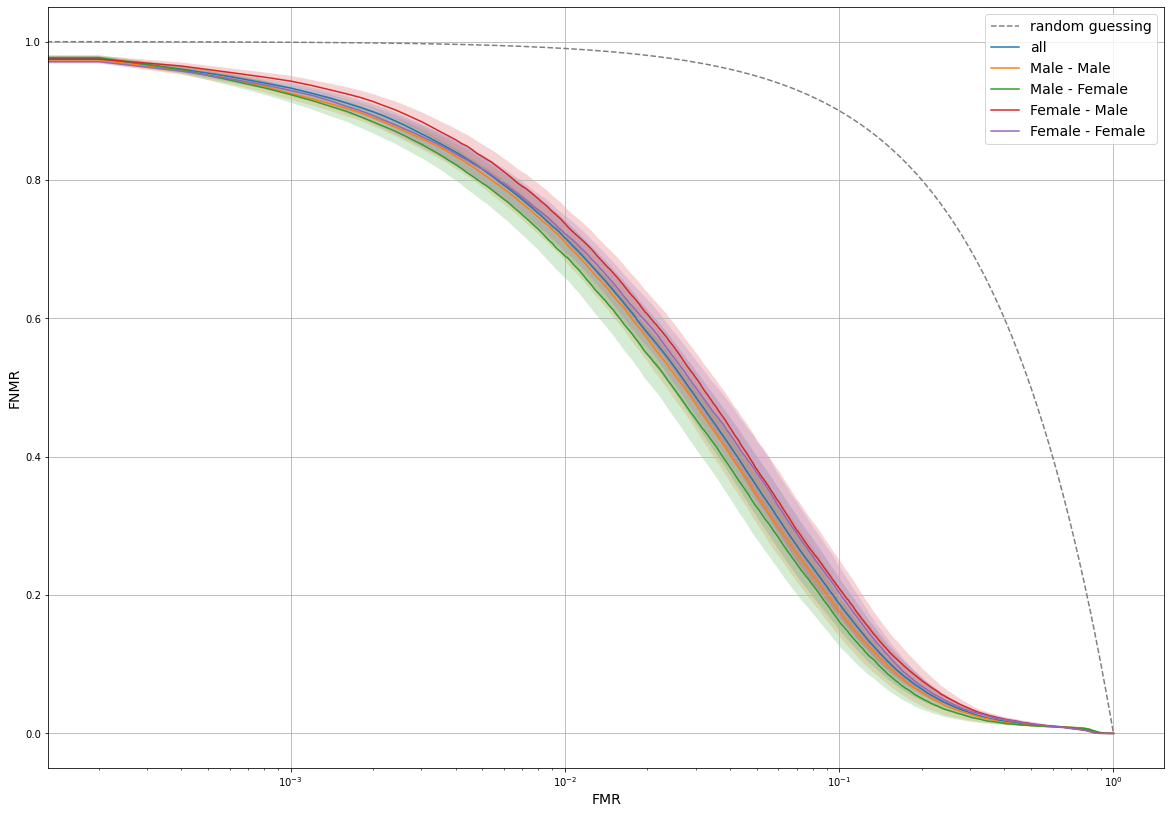

\begin{tabular}{l||rr|rr||c||c} 
\toprule 
$	\tau = FMR_{10^x}$ & $10^{-1}$ & $10^{-2}$ & $10^{-1}$ & $10^{-2}$ &  & \\ \hline 
Demographics  (e-p)& \multicolumn{2}{c|}{$FMR_x(\tau)$}& \multicolumn{2}{c||}{$FNMR_x(\tau)$}& $EER$ & $ROC_{AUC}$ \\ \hline 

Male - Male & 0.103 $ \pm$ 0.001 & 0.01 $ \pm$ 0.001 & 0.17 $ \pm$ 0.033 & 0.701 $ \pm$ 0.028 & 0.123 $ \pm$ 0.01 & 0.939 $ \pm$ 0.008\\
Male - Female & 0.095 $ \pm$ 0.002 & 0.01 $ \pm$ 0.0 & 0.17 $ \pm$ 0.033 & 0.701 $ \pm$ 0.028 & 0.117 $ \pm$ 0.01 & 0.942 $ \pm$ 0.007\\
Female - Male & 0.103 $ \pm$ 0.001 & 0.01 $ \pm$ 0.0 & 0.205 $ \pm$ 0.043 & 0.732 $ \pm$ 0.024 & 0.132 $ \pm$ 0.01 & 0.931 $ \pm$ 0.008\\
Female - Female & 0.1 $ \pm$ 0.002 & 0.01 $ \pm$ 0.001 & 0.205 $ \pm$ 0.043 & 0.732 $ \pm$ 0.024 & 0.129 $ \pm$ 0.009 & 0.933 $ \pm$ 0.008\\
\bottomrule
\end{tabular}
['FXS']


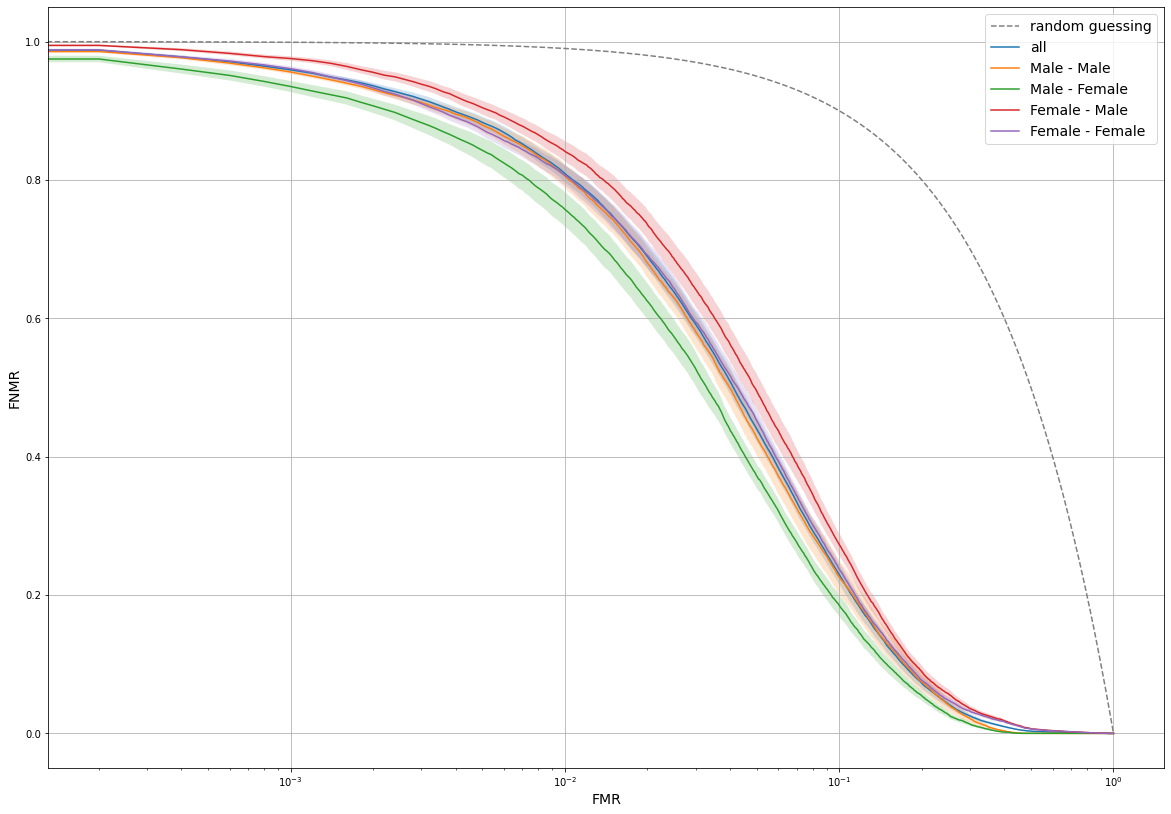

\begin{tabular}{l||rr|rr||c||c} 
\toprule 
$	\tau = FMR_{10^x}$ & $10^{-1}$ & $10^{-2}$ & $10^{-1}$ & $10^{-2}$ &  & \\ \hline 
Demographics  (e-p)& \multicolumn{2}{c|}{$FMR_x(\tau)$}& \multicolumn{2}{c||}{$FNMR_x(\tau)$}& $EER$ & $ROC_{AUC}$ \\ \hline 

Male - Male & 0.103 $ \pm$ 0.004 & 0.012 $ \pm$ 0.001 & 0.218 $ \pm$ 0.018 & 0.787 $ \pm$ 0.015 & 0.14 $ \pm$ 0.007 & 0.933 $ \pm$ 0.005\\
Male - Female & 0.087 $ \pm$ 0.002 & 0.009 $ \pm$ 0.001 & 0.219 $ \pm$ 0.018 & 0.787 $ \pm$ 0.015 & 0.128 $ \pm$ 0.005 & 0.943 $ \pm$ 0.003\\
Female - Male & 0.112 $ \pm$ 0.002 & 0.011 $ \pm$ 0.0 & 0.239 $ \pm$ 0.012 & 0.827 $ \pm$ 0.015 & 0.151 $ \pm$ 0.004 & 0.919 $ \pm$ 0.004\\
Female - Female & 0.101 $ \pm$ 0.005 & 0.009 $ \pm$ 0.001 & 0.239 $ \pm$ 0.012 & 0.827 $ \pm$ 0.015 & 0.144 $ \pm$ 0.003 & 0.927 $ \pm$ 0.002\\
\bottomrule
\end{tabular}
['HSS']


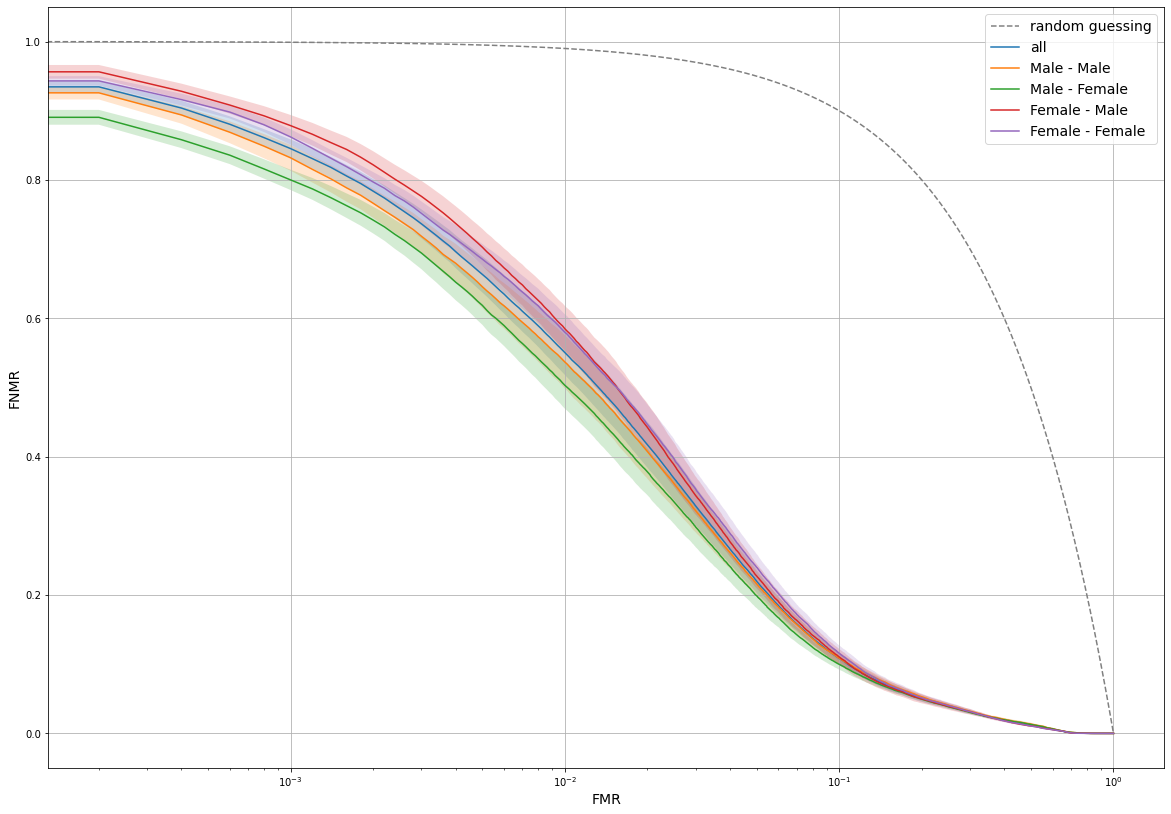

\begin{tabular}{l||rr|rr||c||c} 
\toprule 
$	\tau = FMR_{10^x}$ & $10^{-1}$ & $10^{-2}$ & $10^{-1}$ & $10^{-2}$ &  & \\ \hline 
Demographics  (e-p)& \multicolumn{2}{c|}{$FMR_x(\tau)$}& \multicolumn{2}{c||}{$FNMR_x(\tau)$}& $EER$ & $ROC_{AUC}$ \\ \hline 

Male - Male & 0.103 $ \pm$ 0.002 & 0.011 $ \pm$ 0.001 & 0.105 $ \pm$ 0.008 & 0.523 $ \pm$ 0.035 & 0.103 $ \pm$ 0.004 & 0.955 $ \pm$ 0.003\\
Male - Female & 0.094 $ \pm$ 0.001 & 0.009 $ \pm$ 0.0 & 0.105 $ \pm$ 0.008 & 0.523 $ \pm$ 0.035 & 0.099 $ \pm$ 0.004 & 0.958 $ \pm$ 0.003\\
Female - Male & 0.099 $ \pm$ 0.001 & 0.01 $ \pm$ 0.0 & 0.112 $ \pm$ 0.011 & 0.583 $ \pm$ 0.03 & 0.104 $ \pm$ 0.005 & 0.954 $ \pm$ 0.003\\
Female - Female & 0.104 $ \pm$ 0.002 & 0.01 $ \pm$ 0.001 & 0.112 $ \pm$ 0.011 & 0.583 $ \pm$ 0.03 & 0.106 $ \pm$ 0.005 & 0.953 $ \pm$ 0.003\\
\bottomrule
\end{tabular}
['RAN']


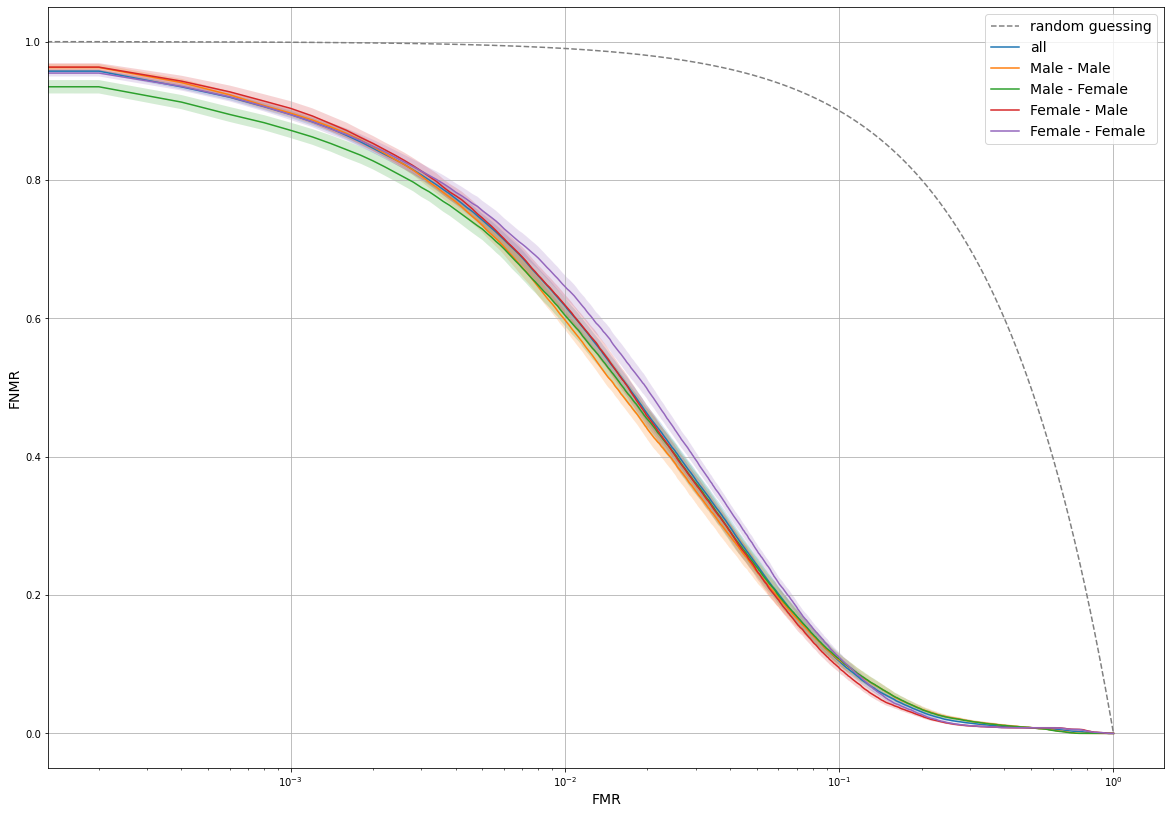

\begin{tabular}{l||rr|rr||c||c} 
\toprule 
$	\tau = FMR_{10^x}$ & $10^{-1}$ & $10^{-2}$ & $10^{-1}$ & $10^{-2}$ &  & \\ \hline 
Demographics  (e-p)& \multicolumn{2}{c|}{$FMR_x(\tau)$}& \multicolumn{2}{c||}{$FNMR_x(\tau)$}& $EER$ & $ROC_{AUC}$ \\ \hline 

Male - Male & 0.093 $ \pm$ 0.001 & 0.009 $ \pm$ 0.0 & 0.117 $ \pm$ 0.009 & 0.617 $ \pm$ 0.013 & 0.103 $ \pm$ 0.004 & 0.958 $ \pm$ 0.002\\
Male - Female & 0.094 $ \pm$ 0.001 & 0.009 $ \pm$ 0.0 & 0.117 $ \pm$ 0.009 & 0.617 $ \pm$ 0.013 & 0.103 $ \pm$ 0.004 & 0.957 $ \pm$ 0.002\\
Female - Male & 0.103 $ \pm$ 0.001 & 0.01 $ \pm$ 0.0 & 0.09 $ \pm$ 0.006 & 0.618 $ \pm$ 0.015 & 0.098 $ \pm$ 0.003 & 0.959 $ \pm$ 0.002\\
Female - Female & 0.112 $ \pm$ 0.002 & 0.012 $ \pm$ 0.0 & 0.09 $ \pm$ 0.006 & 0.618 $ \pm$ 0.015 & 0.104 $ \pm$ 0.003 & 0.956 $ \pm$ 0.002\\
\bottomrule
\end{tabular}
['VD1,VD2']


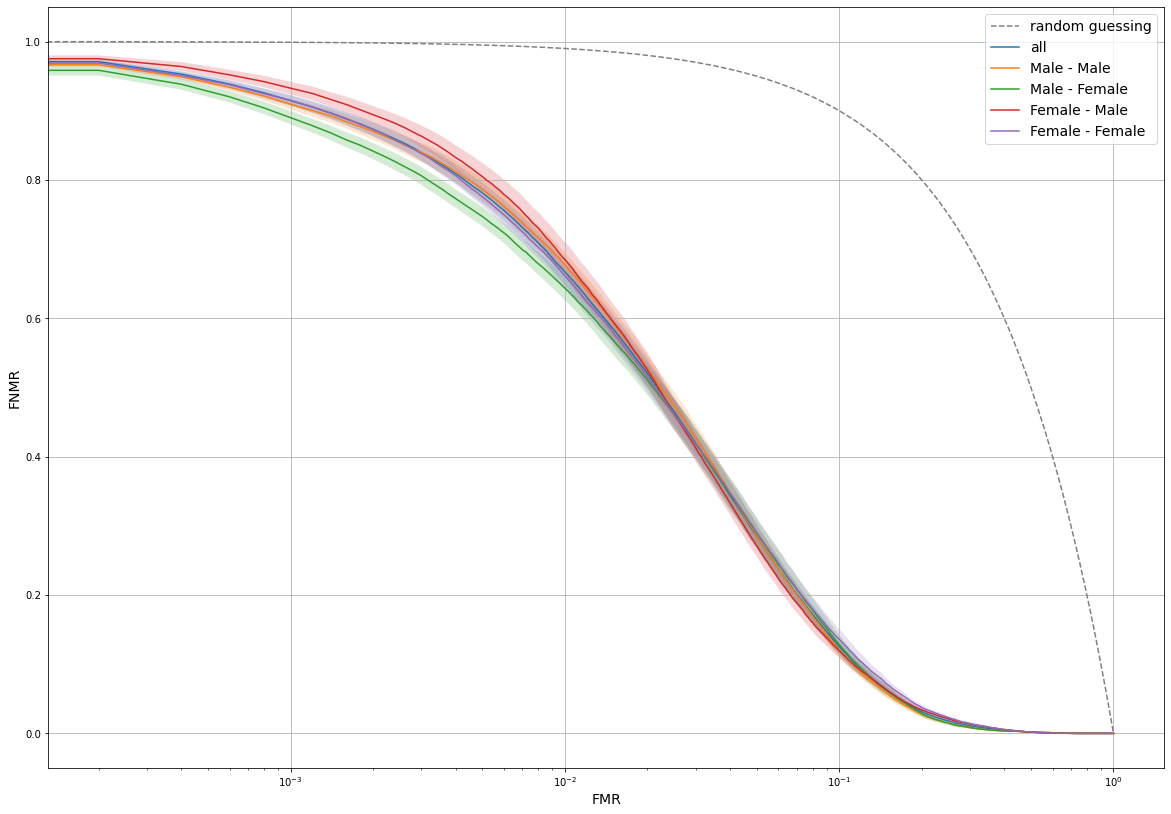

\begin{tabular}{l||rr|rr||c||c} 
\toprule 
$	\tau = FMR_{10^x}$ & $10^{-1}$ & $10^{-2}$ & $10^{-1}$ & $10^{-2}$ &  & \\ \hline 
Demographics  (e-p)& \multicolumn{2}{c|}{$FMR_x(\tau)$}& \multicolumn{2}{c||}{$FNMR_x(\tau)$}& $EER$ & $ROC_{AUC}$ \\ \hline 

Male - Male & 0.097 $ \pm$ 0.002 & 0.011 $ \pm$ 0.0 & 0.129 $ \pm$ 0.013 & 0.661 $ \pm$ 0.018 & 0.107 $ \pm$ 0.004 & 0.956 $ \pm$ 0.002\\
Male - Female & 0.1 $ \pm$ 0.001 & 0.009 $ \pm$ 0.0 & 0.129 $ \pm$ 0.013 & 0.661 $ \pm$ 0.018 & 0.109 $ \pm$ 0.005 & 0.956 $ \pm$ 0.003\\
Female - Male & 0.098 $ \pm$ 0.001 & 0.011 $ \pm$ 0.0 & 0.123 $ \pm$ 0.011 & 0.673 $ \pm$ 0.02 & 0.106 $ \pm$ 0.004 & 0.955 $ \pm$ 0.002\\
Female - Female & 0.106 $ \pm$ 0.002 & 0.009 $ \pm$ 0.001 & 0.123 $ \pm$ 0.011 & 0.673 $ \pm$ 0.02 & 0.112 $ \pm$ 0.004 & 0.953 $ \pm$ 0.003\\
\bottomrule
\end{tabular}



In [25]:
for use_trial_types in tqdm(use_trial_type_list):
    trial_str = str(use_trial_types)
    print(trial_str)
    if trial_str not in gender_metric_dict:
        continue
    counter = 0
    plt.figure(figsize = (20,14))
    for legend_key in gender_metric_dict[trial_str]:
        if counter == 0:
            plot_random = True
        else:
            plot_random = False
        plotting_utils.avg_fnr_fpr_curve(gender_metric_dict[trial_str][legend_key]['fprs'],
                    gender_metric_dict[trial_str][legend_key]['tprs'], 
                    label = legend_key, plot_random=plot_random,
                    title = None, plot_statistics = False,
                    loc = 'best', plot_legend = True,
                    plot_points = 5000, ncol=1,
                    bbox_to_anchor=None,
                    starting_point = None,
                    fontsize = 14, xscale = 'log',
                    setting = 'verification')
        counter += 1
    plt.savefig(plot_save_dir + 'det_curve_gender_' + trial_str + '.pdf')
    plt.show()
    plotting_utils.print_fmr_fnmr_table(gender_metric_dict[trial_str],
                                   gender_fdr_metric_dict[trial_str],
                                   gender_fdr_dict[trial_str],
                                   inspect_thresholds = table_thresholds,
                                   decimals=3,
                                   print_eer = True,
                                   print_roc_auc = True,
                                   compare_key = 'Male - Male')

In [37]:
gender_fdr_auc = plotting_utils.print_fdr_table(gender_metric_dict,
                    gender_fdr_metric_dict,
                    gender_fdr_dict,
                    inspect_thresholds = [0.1,0.01,0.001],
                    use_trial_type_list = [['TEX'],
                       ['BLG'],
                       ['FXS'],
                       ['HSS'],
                       ['RAN'],
                       ['VD1,VD2']],
                    decimals = 2,
                    plot_intersectedAUC= False,
                    plot_fdrAUC = True,
                    fdr_thresholds = [0.1,0.05,0.01,0.005,0.001],
                    fdr_alpha = 0.5)

\begin{tabular}{l||rrr||r}
\toprule 
$	\tau = FMR_{10^x}$ & $10^{-1}$ & $10^{-2}$ & $10^{-3}$ & \\ \hline 
 Task& \multicolumn{3}{c||}{$FDR(\tau)$} & $FDR_{AUC}$ \\ \hline
'TEX' & 0.99 $ \pm$ 0.0 & 0.98 $ \pm$ 0.0 & 0.99 $ \pm$ 0.0 & 0.98 $ \pm$ 0.0*\\
'BLG' & 0.98 $ \pm$ 0.01 & 0.98 $ \pm$ 0.0 & 0.99 $ \pm$ 0.0 & 0.98 $ \pm$ 0.0*\\
'FXS' & 0.97 $ \pm$ 0.0 & 0.97 $ \pm$ 0.01 & 0.99 $ \pm$ 0.0 & 0.97 $ \pm$ 0.01*\\
'HSS' & 0.98 $ \pm$ 0.0 & 0.97 $ \pm$ 0.01 & 0.97 $ \pm$ 0.01 & 0.98 $ \pm$ 0.0*\\
'RAN' & 0.98 $ \pm$ 0.0 & 0.98 $ \pm$ 0.01 & 0.98 $ \pm$ 0.0 & 0.98 $ \pm$ 0.0*\\
'VD1,VD2' & 0.98 $ \pm$ 0.0 & 0.99 $ \pm$ 0.0 & 0.98 $ \pm$ 0.0 & 0.98 $ \pm$ 0.0*\\
\bottomrule
\end{tabular}


# Age on test set with randomly sampled persons (100)

In [27]:
age_metric_dict = dict()
age_fdr_metric_dict = dict()
age_fdr_dict = dict()
for use_trial_types in tqdm(use_trial_type_list):
    trial_str = str(use_trial_types)
    metric_dict = plotting_utils.get_metric_dict_for_setting(inspect_key = 'age_class',
                            inspect_list = ['younger','older'],
                            window_size =  10,
                            num_folds = 10,
                            use_trial_types = use_trial_types,
                            used_train_key = 'random',
                            used_train_percentage = '1',
                            used_train_seconds_per_user = 80,
                            data_dir = 'saved_score_dicts/',
                            demo_dict = demo_dict)
    if len(metric_dict) > 0:
        age_metric_dict[trial_str] = metric_dict
        fdr_metric_dict, fdr_dict = plotting_utils.get_fdr_metric_dict(metric_dict,
                            inspect_thresholds = inspect_thresholds,
                            plot_points = 5000)
        age_fdr_metric_dict[trial_str] = fdr_metric_dict
        age_fdr_dict[trial_str] = fdr_dict

100%|██████████| 10/10 [02:21<00:00, 14.18s/it]

['TEX']


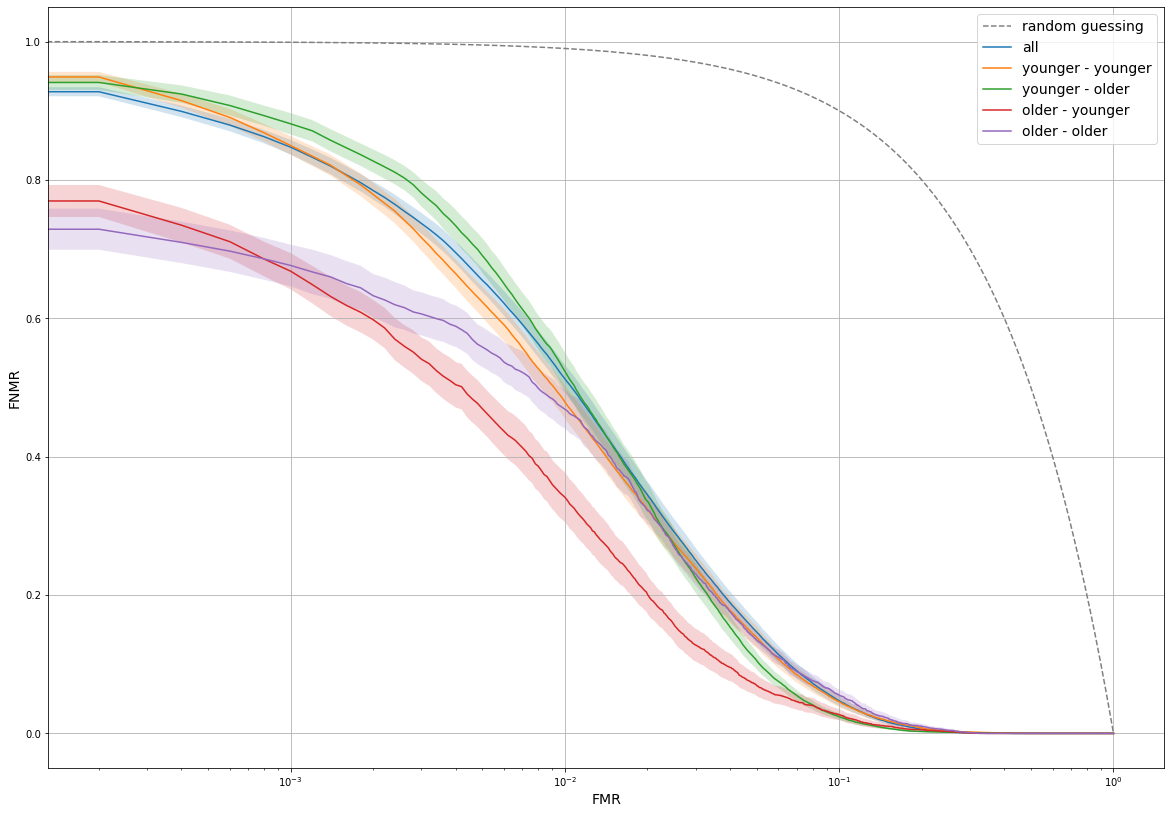

\begin{tabular}{l||rr|rr||c||c} 
\toprule 
$	\tau = FMR_{10^x}$ & $10^{-1}$ & $10^{-2}$ & $10^{-1}$ & $10^{-2}$ &  & \\ \hline 
Demographics  (e-p)& \multicolumn{2}{c|}{$FMR_x(\tau)$}& \multicolumn{2}{c||}{$FNMR_x(\tau)$}& $EER$ & $ROC_{AUC}$ \\ \hline 

younger - younger & 0.101 $ \pm$ 0.003 & 0.007 $ \pm$ 0.0 & 0.044 $ \pm$ 0.007 & 0.557 $ \pm$ 0.022 & 0.075 $ \pm$ 0.004 & 0.976 $ \pm$ 0.002\\
younger - older & 0.077 $ \pm$ 0.002 & 0.009 $ \pm$ 0.001 & 0.044 $ \pm$ 0.007 & 0.557 $ \pm$ 0.022 & 0.064 $ \pm$ 0.003 & 0.979 $ \pm$ 0.002\\
older - younger & 0.064 $ \pm$ 0.004 & 0.007 $ \pm$ 0.001 & 0.051 $ \pm$ 0.013 & 0.421 $ \pm$ 0.031 & 0.058 $ \pm$ 0.006 & 0.985 $ \pm$ 0.002\\
older - older & 0.11 $ \pm$ 0.01 & 0.013 $ \pm$ 0.002 & 0.051 $ \pm$ 0.013 & 0.421 $ \pm$ 0.031 & 0.079 $ \pm$ 0.004 & 0.977 $ \pm$ 0.002\\
\bottomrule
\end{tabular}
['BLG']


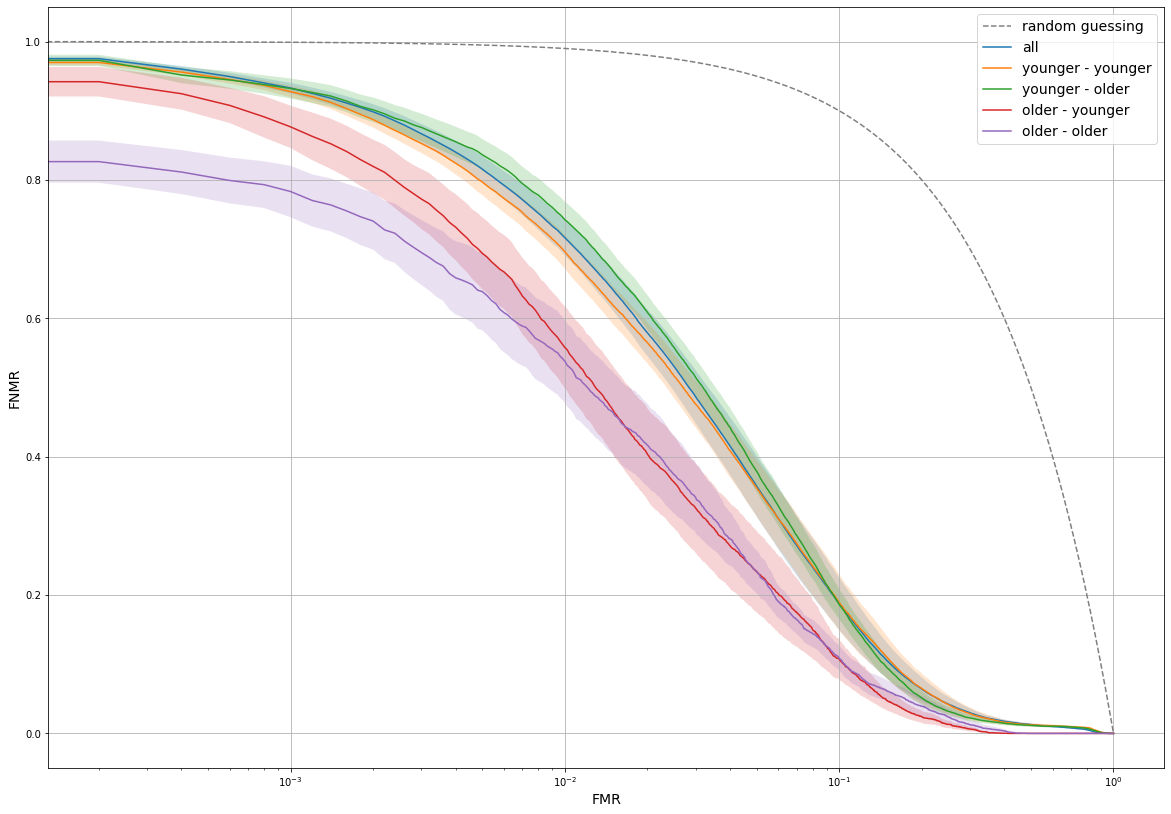

\begin{tabular}{l||rr|rr||c||c} 
\toprule 
$	\tau = FMR_{10^x}$ & $10^{-1}$ & $10^{-2}$ & $10^{-1}$ & $10^{-2}$ &  & \\ \hline 
Demographics  (e-p)& \multicolumn{2}{c|}{$FMR_x(\tau)$}& \multicolumn{2}{c||}{$FNMR_x(\tau)$}& $EER$ & $ROC_{AUC}$ \\ \hline 

younger - younger & 0.099 $ \pm$ 0.002 & 0.008 $ \pm$ 0.001 & 0.191 $ \pm$ 0.036 & 0.734 $ \pm$ 0.027 & 0.127 $ \pm$ 0.011 & 0.936 $ \pm$ 0.009\\
younger - older & 0.106 $ \pm$ 0.009 & 0.011 $ \pm$ 0.002 & 0.191 $ \pm$ 0.036 & 0.734 $ \pm$ 0.027 & 0.127 $ \pm$ 0.007 & 0.937 $ \pm$ 0.005\\
older - younger & 0.089 $ \pm$ 0.005 & 0.009 $ \pm$ 0.001 & 0.163 $ \pm$ 0.055 & 0.583 $ \pm$ 0.058 & 0.095 $ \pm$ 0.009 & 0.964 $ \pm$ 0.007\\
older - older & 0.11 $ \pm$ 0.016 & 0.011 $ \pm$ 0.004 & 0.163 $ \pm$ 0.055 & 0.584 $ \pm$ 0.057 & 0.104 $ \pm$ 0.008 & 0.962 $ \pm$ 0.006\\
\bottomrule
\end{tabular}
['FXS']


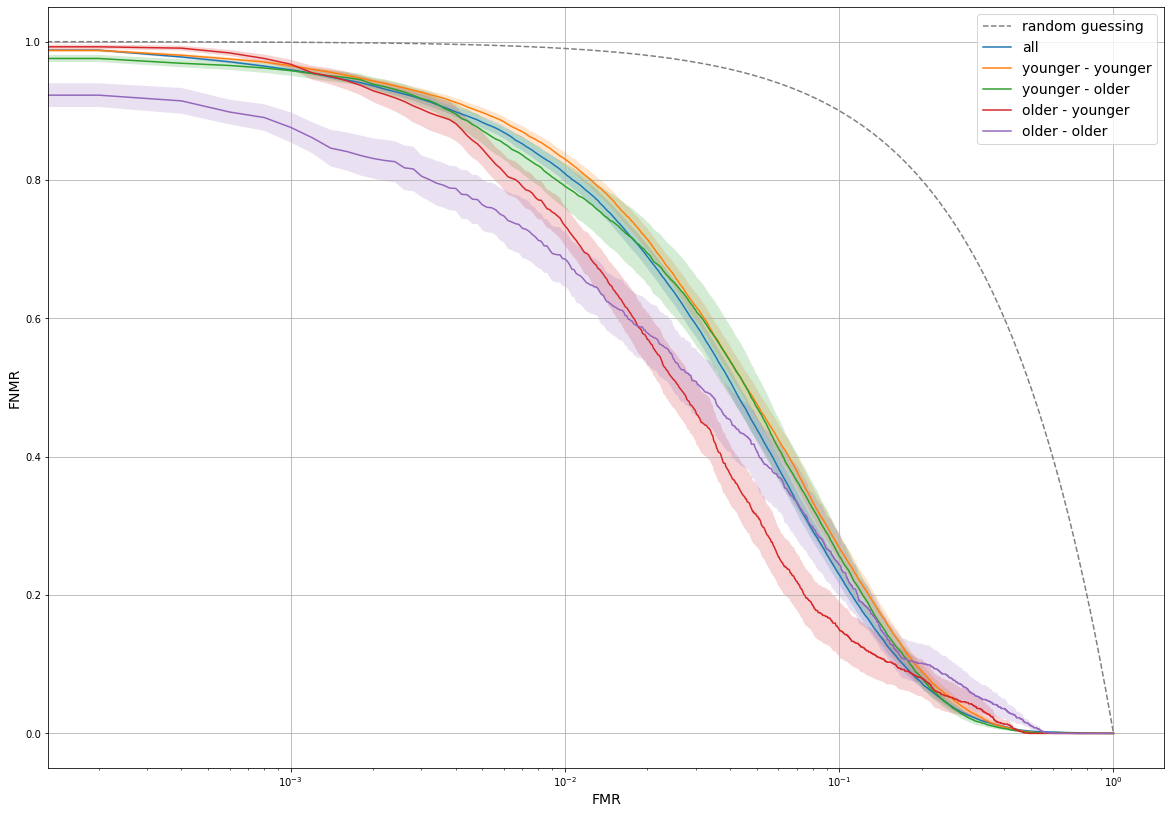

\begin{tabular}{l||rr|rr||c||c} 
\toprule 
$	\tau = FMR_{10^x}$ & $10^{-1}$ & $10^{-2}$ & $10^{-1}$ & $10^{-2}$ &  & \\ \hline 
Demographics  (e-p)& \multicolumn{2}{c|}{$FMR_x(\tau)$}& \multicolumn{2}{c||}{$FNMR_x(\tau)$}& $EER$ & $ROC_{AUC}$ \\ \hline 

younger - younger & 0.107 $ \pm$ 0.004 & 0.009 $ \pm$ 0.001 & 0.25 $ \pm$ 0.014 & 0.844 $ \pm$ 0.014 & 0.152 $ \pm$ 0.005 & 0.923 $ \pm$ 0.004\\
younger - older & 0.099 $ \pm$ 0.009 & 0.009 $ \pm$ 0.001 & 0.25 $ \pm$ 0.015 & 0.844 $ \pm$ 0.014 & 0.145 $ \pm$ 0.007 & 0.927 $ \pm$ 0.007\\
older - younger & 0.09 $ \pm$ 0.003 & 0.01 $ \pm$ 0.001 & 0.165 $ \pm$ 0.041 & 0.723 $ \pm$ 0.033 & 0.127 $ \pm$ 0.017 & 0.942 $ \pm$ 0.01\\
older - older & 0.126 $ \pm$ 0.011 & 0.01 $ \pm$ 0.003 & 0.164 $ \pm$ 0.041 & 0.722 $ \pm$ 0.033 & 0.152 $ \pm$ 0.016 & 0.925 $ \pm$ 0.011\\
\bottomrule
\end{tabular}
['HSS']


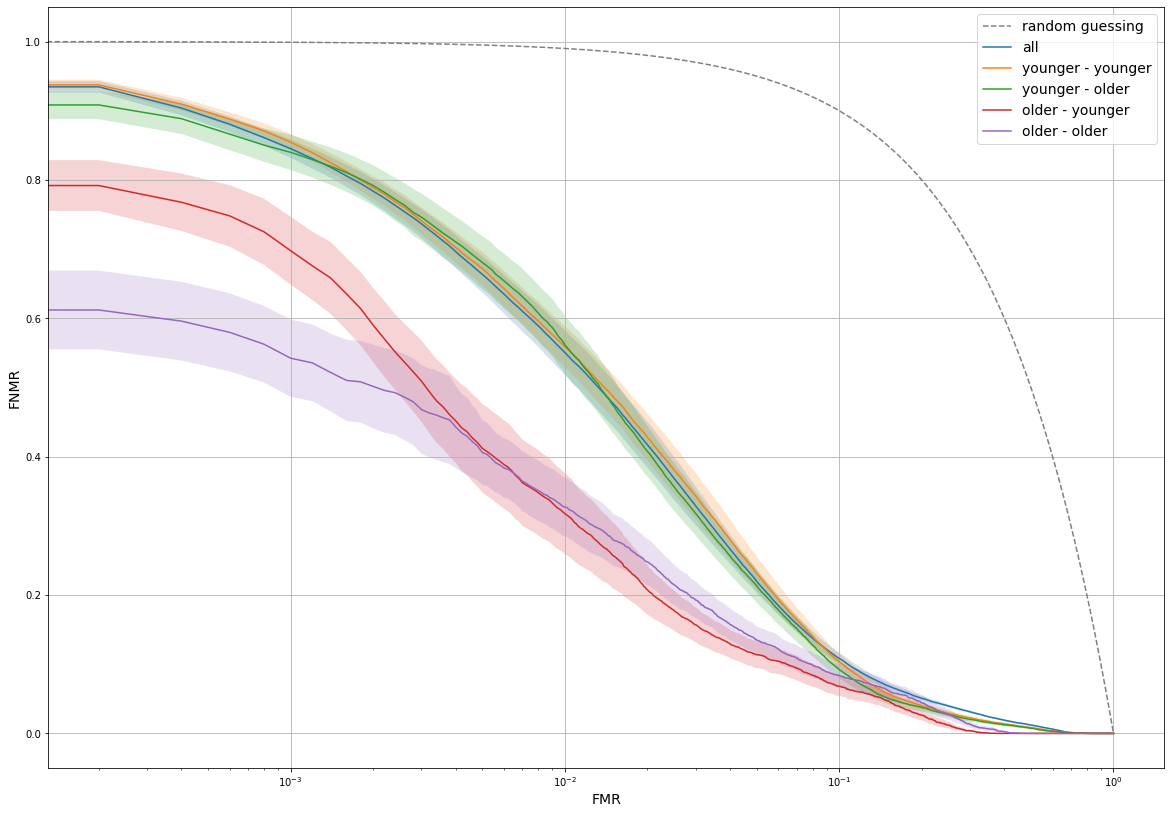

\begin{tabular}{l||rr|rr||c||c} 
\toprule 
$	\tau = FMR_{10^x}$ & $10^{-1}$ & $10^{-2}$ & $10^{-1}$ & $10^{-2}$ &  & \\ \hline 
Demographics  (e-p)& \multicolumn{2}{c|}{$FMR_x(\tau)$}& \multicolumn{2}{c||}{$FNMR_x(\tau)$}& $EER$ & $ROC_{AUC}$ \\ \hline 

younger - younger & 0.105 $ \pm$ 0.002 & 0.009 $ \pm$ 0.0 & 0.097 $ \pm$ 0.01 & 0.58 $ \pm$ 0.027 & 0.101 $ \pm$ 0.005 & 0.958 $ \pm$ 0.003\\
younger - older & 0.095 $ \pm$ 0.006 & 0.01 $ \pm$ 0.001 & 0.097 $ \pm$ 0.01 & 0.58 $ \pm$ 0.027 & 0.096 $ \pm$ 0.006 & 0.961 $ \pm$ 0.004\\
older - younger & 0.066 $ \pm$ 0.004 & 0.005 $ \pm$ 0.0 & 0.102 $ \pm$ 0.019 & 0.407 $ \pm$ 0.062 & 0.079 $ \pm$ 0.01 & 0.978 $ \pm$ 0.004\\
older - older & 0.096 $ \pm$ 0.013 & 0.009 $ \pm$ 0.004 & 0.102 $ \pm$ 0.019 & 0.402 $ \pm$ 0.063 & 0.091 $ \pm$ 0.011 & 0.972 $ \pm$ 0.004\\
\bottomrule
\end{tabular}
['RAN']


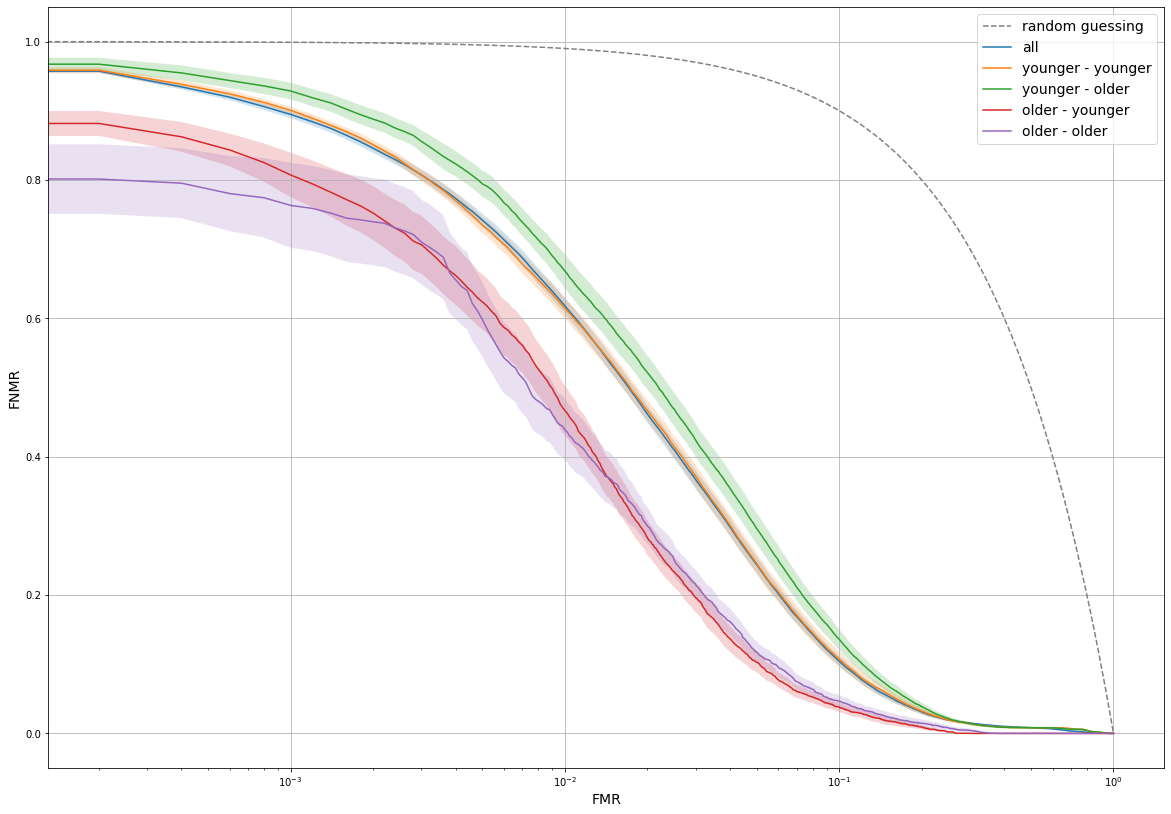

\begin{tabular}{l||rr|rr||c||c} 
\toprule 
$	\tau = FMR_{10^x}$ & $10^{-1}$ & $10^{-2}$ & $10^{-1}$ & $10^{-2}$ &  & \\ \hline 
Demographics  (e-p)& \multicolumn{2}{c|}{$FMR_x(\tau)$}& \multicolumn{2}{c||}{$FNMR_x(\tau)$}& $EER$ & $ROC_{AUC}$ \\ \hline 

younger - younger & 0.093 $ \pm$ 0.002 & 0.008 $ \pm$ 0.0 & 0.118 $ \pm$ 0.01 & 0.657 $ \pm$ 0.011 & 0.103 $ \pm$ 0.004 & 0.956 $ \pm$ 0.003\\
younger - older & 0.108 $ \pm$ 0.004 & 0.011 $ \pm$ 0.001 & 0.118 $ \pm$ 0.01 & 0.656 $ \pm$ 0.012 & 0.112 $ \pm$ 0.005 & 0.95 $ \pm$ 0.004\\
older - younger & 0.085 $ \pm$ 0.003 & 0.007 $ \pm$ 0.001 & 0.048 $ \pm$ 0.008 & 0.57 $ \pm$ 0.035 & 0.065 $ \pm$ 0.004 & 0.979 $ \pm$ 0.002\\
older - older & 0.098 $ \pm$ 0.006 & 0.007 $ \pm$ 0.002 & 0.048 $ \pm$ 0.008 & 0.568 $ \pm$ 0.035 & 0.071 $ \pm$ 0.005 & 0.977 $ \pm$ 0.002\\
\bottomrule
\end{tabular}
['VD1,VD2']


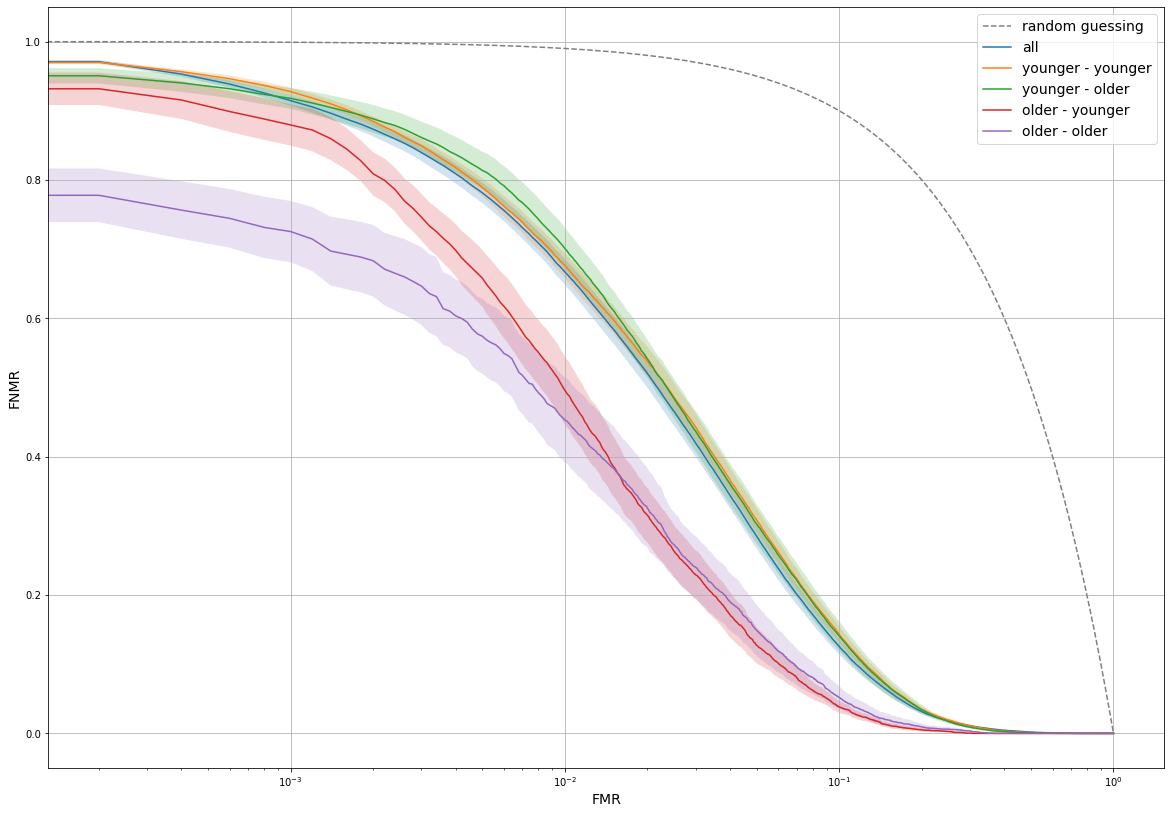

\begin{tabular}{l||rr|rr||c||c} 
\toprule 
$	\tau = FMR_{10^x}$ & $10^{-1}$ & $10^{-2}$ & $10^{-1}$ & $10^{-2}$ &  & \\ \hline 
Demographics  (e-p)& \multicolumn{2}{c|}{$FMR_x(\tau)$}& \multicolumn{2}{c||}{$FNMR_x(\tau)$}& $EER$ & $ROC_{AUC}$ \\ \hline 

younger - younger & 0.099 $ \pm$ 0.004 & 0.008 $ \pm$ 0.001 & 0.147 $ \pm$ 0.015 & 0.713 $ \pm$ 0.019 & 0.114 $ \pm$ 0.004 & 0.952 $ \pm$ 0.002\\
younger - older & 0.095 $ \pm$ 0.005 & 0.01 $ \pm$ 0.001 & 0.147 $ \pm$ 0.015 & 0.713 $ \pm$ 0.019 & 0.112 $ \pm$ 0.006 & 0.953 $ \pm$ 0.004\\
older - younger & 0.081 $ \pm$ 0.005 & 0.008 $ \pm$ 0.001 & 0.063 $ \pm$ 0.014 & 0.549 $ \pm$ 0.039 & 0.068 $ \pm$ 0.006 & 0.978 $ \pm$ 0.003\\
older - older & 0.088 $ \pm$ 0.013 & 0.009 $ \pm$ 0.003 & 0.063 $ \pm$ 0.014 & 0.547 $ \pm$ 0.04 & 0.073 $ \pm$ 0.008 & 0.976 $ \pm$ 0.005\\
\bottomrule
\end{tabular}



In [28]:
for use_trial_types in tqdm(use_trial_type_list):
    trial_str = str(use_trial_types)
    print(trial_str)
    if trial_str not in age_metric_dict:
        continue
    counter = 0
    plt.figure(figsize = (20,14))
    for legend_key in age_metric_dict[trial_str]:
        if counter == 0:
            plot_random = True
        else:
            plot_random = False
        plotting_utils.avg_fnr_fpr_curve(age_metric_dict[trial_str][legend_key]['fprs'],
                    age_metric_dict[trial_str][legend_key]['tprs'], 
                    label = legend_key, plot_random=plot_random,
                    title = None, plot_statistics = False,
                    loc = 'best', plot_legend = True,
                    plot_points = 5000, ncol=1,
                    bbox_to_anchor=None,
                    starting_point = None,
                    fontsize = 14, xscale = 'log',
                    setting = 'verification')
        counter += 1
    plt.savefig(plot_save_dir + 'det_curve_age_' + trial_str + '.pdf')
    plt.show()
    plotting_utils.print_fmr_fnmr_table(age_metric_dict[trial_str],
                                   age_fdr_metric_dict[trial_str],
                                   age_fdr_dict[trial_str],
                                   inspect_thresholds = table_thresholds,
                                   decimals=3,
                                   print_eer = True,
                                   print_roc_auc = True,
                                   compare_key = 'younger - younger')

In [38]:
age_fdr_auc = plotting_utils.print_fdr_table(age_metric_dict,
                    age_fdr_metric_dict,
                    age_fdr_dict,
                    inspect_thresholds = [0.1,0.01,0.001],
                    use_trial_type_list = [['TEX'],
                       ['BLG'],
                       ['FXS'],
                       ['HSS'],
                       ['RAN'],
                       ['VD1,VD2']],
                    decimals = 2,
                    plot_intersectedAUC = False,
                    plot_fdrAUC = True,
                    fdr_thresholds = [0.1,0.05,0.01,0.005,0.001],
                    fdr_alpha = 0.5)

\begin{tabular}{l||rrr||r}
\toprule 
$	\tau = FMR_{10^x}$ & $10^{-1}$ & $10^{-2}$ & $10^{-3}$ & \\ \hline 
 Task& \multicolumn{3}{c||}{$FDR(\tau)$} & $FDR_{AUC}$ \\ \hline
'TEX' & 0.97 $ \pm$ 0.0 & 0.93 $ \pm$ 0.01 & 0.91 $ \pm$ 0.01 & 0.95 $ \pm$ 0.0*\\
'BLG' & 0.94 $ \pm$ 0.01 & 0.91 $ \pm$ 0.01 & 0.96 $ \pm$ 0.01 & 0.92 $ \pm$ 0.01*\\
'FXS' & 0.91 $ \pm$ 0.01 & 0.93 $ \pm$ 0.02 & 0.98 $ \pm$ 0.01 & 0.91 $ \pm$ 0.01\\
'HSS' & 0.96 $ \pm$ 0.01 & 0.91 $ \pm$ 0.02 & 0.87 $ \pm$ 0.02 & 0.93 $ \pm$ 0.01*\\
'RAN' & 0.95 $ \pm$ 0.01 & 0.94 $ \pm$ 0.01 & 0.93 $ \pm$ 0.02 & 0.94 $ \pm$ 0.01*\\
'VD1,VD2' & 0.94 $ \pm$ 0.01 & 0.91 $ \pm$ 0.02 & 0.94 $ \pm$ 0.01 & 0.92 $ \pm$ 0.01\\
\bottomrule
\end{tabular}


In [30]:
age_metric_dict["['TEX']"].keys()

dict_keys(['all', 'younger - younger', 'younger - older', 'older - younger', 'older - older'])

### Ethnicity: Plot FDR and EER for different train distributions only e == p

100%|██████████| 10/10 [03:33<00:00, 21.39s/it]


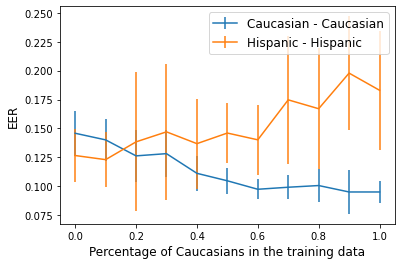

  0%|          | 0/10 [00:00<?, ?it/s]

saved_score_dicts/key_Self-Identified_Ethnicity_list_['White',_'Hispanic']_trials_['BLG']_fold_8_percentage_[0.0, 1.0]_seconds_per_user_80.joblib does not exist
saved_score_dicts/key_Self-Identified_Ethnicity_list_['White',_'Hispanic']_trials_['BLG']_fold_9_percentage_[0.0, 1.0]_seconds_per_user_80.joblib does not exist


  0%|          | 0/10 [00:00<?, ?it/s]

saved_score_dicts/key_Self-Identified_Ethnicity_list_['White',_'Hispanic']_trials_['BLG']_fold_8_percentage_[0.1, 0.9]_seconds_per_user_80.joblib does not exist
saved_score_dicts/key_Self-Identified_Ethnicity_list_['White',_'Hispanic']_trials_['BLG']_fold_9_percentage_[0.1, 0.9]_seconds_per_user_80.joblib does not exist


  0%|          | 0/10 [00:00<?, ?it/s]

saved_score_dicts/key_Self-Identified_Ethnicity_list_['White',_'Hispanic']_trials_['BLG']_fold_7_percentage_[0.2, 0.8]_seconds_per_user_80.joblib does not exist
saved_score_dicts/key_Self-Identified_Ethnicity_list_['White',_'Hispanic']_trials_['BLG']_fold_8_percentage_[0.2, 0.8]_seconds_per_user_80.joblib does not exist
saved_score_dicts/key_Self-Identified_Ethnicity_list_['White',_'Hispanic']_trials_['BLG']_fold_9_percentage_[0.2, 0.8]_seconds_per_user_80.joblib does not exist


  0%|          | 0/10 [00:00<?, ?it/s]

saved_score_dicts/key_Self-Identified_Ethnicity_list_['White',_'Hispanic']_trials_['BLG']_fold_7_percentage_[0.3, 0.7]_seconds_per_user_80.joblib does not exist
saved_score_dicts/key_Self-Identified_Ethnicity_list_['White',_'Hispanic']_trials_['BLG']_fold_8_percentage_[0.3, 0.7]_seconds_per_user_80.joblib does not exist
saved_score_dicts/key_Self-Identified_Ethnicity_list_['White',_'Hispanic']_trials_['BLG']_fold_9_percentage_[0.3, 0.7]_seconds_per_user_80.joblib does not exist


  0%|          | 0/10 [00:00<?, ?it/s]

saved_score_dicts/key_Self-Identified_Ethnicity_list_['White',_'Hispanic']_trials_['BLG']_fold_7_percentage_[0.4, 0.6]_seconds_per_user_80.joblib does not exist
saved_score_dicts/key_Self-Identified_Ethnicity_list_['White',_'Hispanic']_trials_['BLG']_fold_8_percentage_[0.4, 0.6]_seconds_per_user_80.joblib does not exist
saved_score_dicts/key_Self-Identified_Ethnicity_list_['White',_'Hispanic']_trials_['BLG']_fold_9_percentage_[0.4, 0.6]_seconds_per_user_80.joblib does not exist


  0%|          | 0/10 [00:00<?, ?it/s]

saved_score_dicts/key_Self-Identified_Ethnicity_list_['White',_'Hispanic']_trials_['BLG']_fold_7_percentage_[0.6, 0.4]_seconds_per_user_80.joblib does not exist
saved_score_dicts/key_Self-Identified_Ethnicity_list_['White',_'Hispanic']_trials_['BLG']_fold_8_percentage_[0.6, 0.4]_seconds_per_user_80.joblib does not exist
saved_score_dicts/key_Self-Identified_Ethnicity_list_['White',_'Hispanic']_trials_['BLG']_fold_9_percentage_[0.6, 0.4]_seconds_per_user_80.joblib does not exist


  0%|          | 0/10 [00:00<?, ?it/s]

saved_score_dicts/key_Self-Identified_Ethnicity_list_['White',_'Hispanic']_trials_['BLG']_fold_7_percentage_[0.7, 0.3]_seconds_per_user_80.joblib does not exist
saved_score_dicts/key_Self-Identified_Ethnicity_list_['White',_'Hispanic']_trials_['BLG']_fold_8_percentage_[0.7, 0.3]_seconds_per_user_80.joblib does not exist
saved_score_dicts/key_Self-Identified_Ethnicity_list_['White',_'Hispanic']_trials_['BLG']_fold_9_percentage_[0.7, 0.3]_seconds_per_user_80.joblib does not exist


  0%|          | 0/10 [00:00<?, ?it/s]

saved_score_dicts/key_Self-Identified_Ethnicity_list_['White',_'Hispanic']_trials_['BLG']_fold_7_percentage_[0.8, 0.2]_seconds_per_user_80.joblib does not exist
saved_score_dicts/key_Self-Identified_Ethnicity_list_['White',_'Hispanic']_trials_['BLG']_fold_8_percentage_[0.8, 0.2]_seconds_per_user_80.joblib does not exist
saved_score_dicts/key_Self-Identified_Ethnicity_list_['White',_'Hispanic']_trials_['BLG']_fold_9_percentage_[0.8, 0.2]_seconds_per_user_80.joblib does not exist


  0%|          | 0/10 [00:00<?, ?it/s]

saved_score_dicts/key_Self-Identified_Ethnicity_list_['White',_'Hispanic']_trials_['BLG']_fold_7_percentage_[0.9, 0.1]_seconds_per_user_80.joblib does not exist
saved_score_dicts/key_Self-Identified_Ethnicity_list_['White',_'Hispanic']_trials_['BLG']_fold_8_percentage_[0.9, 0.1]_seconds_per_user_80.joblib does not exist
saved_score_dicts/key_Self-Identified_Ethnicity_list_['White',_'Hispanic']_trials_['BLG']_fold_9_percentage_[0.9, 0.1]_seconds_per_user_80.joblib does not exist


100%|██████████| 10/10 [02:32<00:00, 15.27s/it]


saved_score_dicts/key_Self-Identified_Ethnicity_list_['White',_'Hispanic']_trials_['BLG']_fold_7_percentage_[1.0, 0.0]_seconds_per_user_80.joblib does not exist
saved_score_dicts/key_Self-Identified_Ethnicity_list_['White',_'Hispanic']_trials_['BLG']_fold_8_percentage_[1.0, 0.0]_seconds_per_user_80.joblib does not exist
saved_score_dicts/key_Self-Identified_Ethnicity_list_['White',_'Hispanic']_trials_['BLG']_fold_9_percentage_[1.0, 0.0]_seconds_per_user_80.joblib does not exist



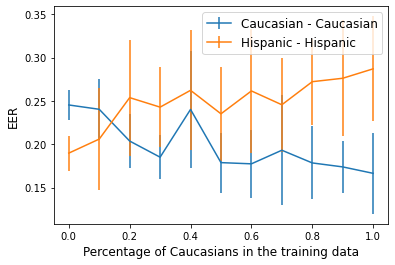

100%|██████████| 10/10 [01:40<00:00, 10.08s/it]


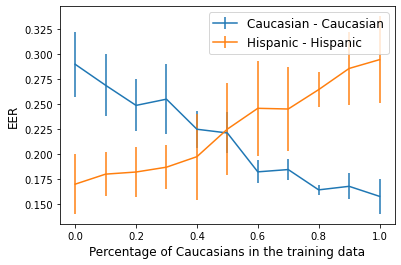

100%|██████████| 10/10 [03:32<00:00, 21.26s/it]


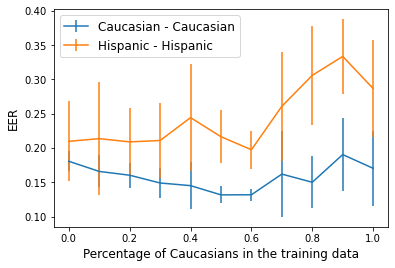

100%|██████████| 10/10 [03:34<00:00, 21.50s/it]


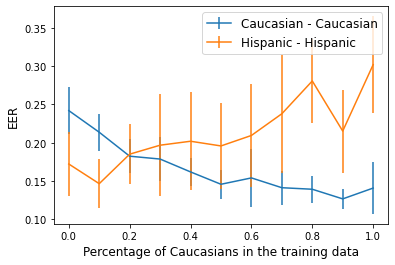

100%|██████████| 10/10 [03:43<00:00, 22.36s/it]


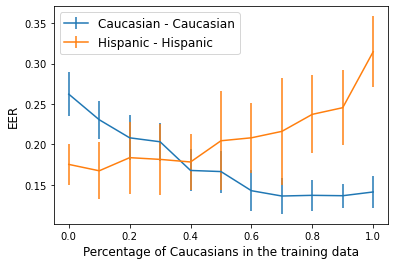

In [31]:
train_distributions = np.arange(0,1.1,0.1)
stimuli_lists = [   ['TEX'],
                    ['BLG'],
                    ['FXS'],
                    ['HSS'],
                    ['RAN'],
                    ['VD1,VD2']]
for stimuli in stimuli_lists:
    per_ethnicity_metric_dict = dict()
    per_ethnicity_fdr_metric_dict = dict()
    per_ethnicity_fdr_dict = dict()
    for train_percentage in tqdm(train_distributions):
        cur_percentage_str = '[' + str(np.round(train_percentage,decimals=1)) +\
                            ', ' + str(np.round(1.0 - train_percentage,decimals=1)) + ']'
        metric_dict = plotting_utils.get_metric_dict_for_setting(inspect_key = 'normalized Ethnicity',
                                inspect_list = ['Caucasian','Hispanic'],
                                window_size =  10,
                                num_folds = 10,
                                use_trial_types = stimuli,
                                used_train_key = "Self-Identified_Ethnicity_list_['White',_'Hispanic']",
                                used_train_percentage = cur_percentage_str,
                                used_train_seconds_per_user = 80,
                                data_dir = 'saved_score_dicts/',
                                demo_dict = demo_dict)
        if len(metric_dict) > 0:
            per_ethnicity_metric_dict[train_percentage] = metric_dict
            fdr_metric_dict, fdr_dict = plotting_utils.get_fdr_metric_dict(metric_dict,
                                inspect_thresholds = inspect_thresholds,
                                plot_points = 5000)
            per_ethnicity_fdr_metric_dict[train_percentage] = fdr_metric_dict
            per_ethnicity_fdr_dict[train_percentage] = fdr_dict

    plotting_utils.plot_eer_percentage(per_ethnicity_fdr_metric_dict,
                            x_label = 'Percentage of Caucasians in the training data',
                            y_label = 'EER',
                            font_size = 12,
                            flag_only_e_equals_p = True)
    plt.savefig('plots/eer_ethnicty_deepeye_' +\
                    str(stimuli) + '_e==p.pdf')
    plt.show()

### Ethnicity: Plot FDR and EER for different train distributions

100%|██████████| 10/10 [03:28<00:00, 20.89s/it]


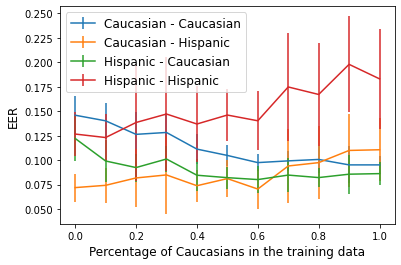

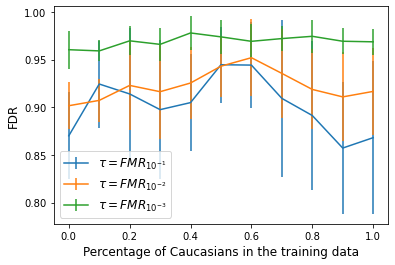

  0%|          | 0/10 [00:00<?, ?it/s]

saved_score_dicts/key_Self-Identified_Ethnicity_list_['White',_'Hispanic']_trials_['BLG']_fold_8_percentage_[0.0, 1.0]_seconds_per_user_80.joblib does not exist
saved_score_dicts/key_Self-Identified_Ethnicity_list_['White',_'Hispanic']_trials_['BLG']_fold_9_percentage_[0.0, 1.0]_seconds_per_user_80.joblib does not exist


  0%|          | 0/10 [00:00<?, ?it/s]

saved_score_dicts/key_Self-Identified_Ethnicity_list_['White',_'Hispanic']_trials_['BLG']_fold_8_percentage_[0.1, 0.9]_seconds_per_user_80.joblib does not exist
saved_score_dicts/key_Self-Identified_Ethnicity_list_['White',_'Hispanic']_trials_['BLG']_fold_9_percentage_[0.1, 0.9]_seconds_per_user_80.joblib does not exist


  0%|          | 0/10 [00:00<?, ?it/s]

saved_score_dicts/key_Self-Identified_Ethnicity_list_['White',_'Hispanic']_trials_['BLG']_fold_7_percentage_[0.2, 0.8]_seconds_per_user_80.joblib does not exist
saved_score_dicts/key_Self-Identified_Ethnicity_list_['White',_'Hispanic']_trials_['BLG']_fold_8_percentage_[0.2, 0.8]_seconds_per_user_80.joblib does not exist
saved_score_dicts/key_Self-Identified_Ethnicity_list_['White',_'Hispanic']_trials_['BLG']_fold_9_percentage_[0.2, 0.8]_seconds_per_user_80.joblib does not exist


  0%|          | 0/10 [00:00<?, ?it/s]

saved_score_dicts/key_Self-Identified_Ethnicity_list_['White',_'Hispanic']_trials_['BLG']_fold_7_percentage_[0.3, 0.7]_seconds_per_user_80.joblib does not exist
saved_score_dicts/key_Self-Identified_Ethnicity_list_['White',_'Hispanic']_trials_['BLG']_fold_8_percentage_[0.3, 0.7]_seconds_per_user_80.joblib does not exist
saved_score_dicts/key_Self-Identified_Ethnicity_list_['White',_'Hispanic']_trials_['BLG']_fold_9_percentage_[0.3, 0.7]_seconds_per_user_80.joblib does not exist


  0%|          | 0/10 [00:00<?, ?it/s]

saved_score_dicts/key_Self-Identified_Ethnicity_list_['White',_'Hispanic']_trials_['BLG']_fold_7_percentage_[0.4, 0.6]_seconds_per_user_80.joblib does not exist
saved_score_dicts/key_Self-Identified_Ethnicity_list_['White',_'Hispanic']_trials_['BLG']_fold_8_percentage_[0.4, 0.6]_seconds_per_user_80.joblib does not exist
saved_score_dicts/key_Self-Identified_Ethnicity_list_['White',_'Hispanic']_trials_['BLG']_fold_9_percentage_[0.4, 0.6]_seconds_per_user_80.joblib does not exist


  0%|          | 0/10 [00:00<?, ?it/s]

saved_score_dicts/key_Self-Identified_Ethnicity_list_['White',_'Hispanic']_trials_['BLG']_fold_7_percentage_[0.6, 0.4]_seconds_per_user_80.joblib does not exist
saved_score_dicts/key_Self-Identified_Ethnicity_list_['White',_'Hispanic']_trials_['BLG']_fold_8_percentage_[0.6, 0.4]_seconds_per_user_80.joblib does not exist
saved_score_dicts/key_Self-Identified_Ethnicity_list_['White',_'Hispanic']_trials_['BLG']_fold_9_percentage_[0.6, 0.4]_seconds_per_user_80.joblib does not exist


  0%|          | 0/10 [00:00<?, ?it/s]

saved_score_dicts/key_Self-Identified_Ethnicity_list_['White',_'Hispanic']_trials_['BLG']_fold_7_percentage_[0.7, 0.3]_seconds_per_user_80.joblib does not exist
saved_score_dicts/key_Self-Identified_Ethnicity_list_['White',_'Hispanic']_trials_['BLG']_fold_8_percentage_[0.7, 0.3]_seconds_per_user_80.joblib does not exist
saved_score_dicts/key_Self-Identified_Ethnicity_list_['White',_'Hispanic']_trials_['BLG']_fold_9_percentage_[0.7, 0.3]_seconds_per_user_80.joblib does not exist


  0%|          | 0/10 [00:00<?, ?it/s]

saved_score_dicts/key_Self-Identified_Ethnicity_list_['White',_'Hispanic']_trials_['BLG']_fold_7_percentage_[0.8, 0.2]_seconds_per_user_80.joblib does not exist
saved_score_dicts/key_Self-Identified_Ethnicity_list_['White',_'Hispanic']_trials_['BLG']_fold_8_percentage_[0.8, 0.2]_seconds_per_user_80.joblib does not exist
saved_score_dicts/key_Self-Identified_Ethnicity_list_['White',_'Hispanic']_trials_['BLG']_fold_9_percentage_[0.8, 0.2]_seconds_per_user_80.joblib does not exist


  0%|          | 0/10 [00:00<?, ?it/s]

saved_score_dicts/key_Self-Identified_Ethnicity_list_['White',_'Hispanic']_trials_['BLG']_fold_7_percentage_[0.9, 0.1]_seconds_per_user_80.joblib does not exist
saved_score_dicts/key_Self-Identified_Ethnicity_list_['White',_'Hispanic']_trials_['BLG']_fold_8_percentage_[0.9, 0.1]_seconds_per_user_80.joblib does not exist
saved_score_dicts/key_Self-Identified_Ethnicity_list_['White',_'Hispanic']_trials_['BLG']_fold_9_percentage_[0.9, 0.1]_seconds_per_user_80.joblib does not exist


100%|██████████| 10/10 [02:28<00:00, 14.82s/it]


saved_score_dicts/key_Self-Identified_Ethnicity_list_['White',_'Hispanic']_trials_['BLG']_fold_7_percentage_[1.0, 0.0]_seconds_per_user_80.joblib does not exist
saved_score_dicts/key_Self-Identified_Ethnicity_list_['White',_'Hispanic']_trials_['BLG']_fold_8_percentage_[1.0, 0.0]_seconds_per_user_80.joblib does not exist
saved_score_dicts/key_Self-Identified_Ethnicity_list_['White',_'Hispanic']_trials_['BLG']_fold_9_percentage_[1.0, 0.0]_seconds_per_user_80.joblib does not exist



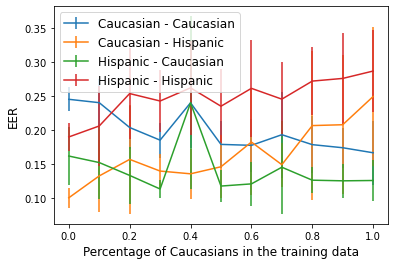

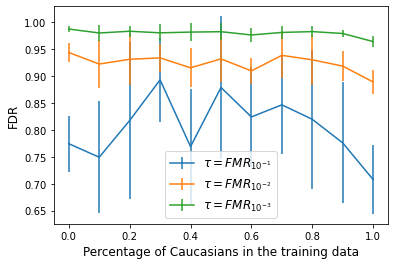

100%|██████████| 10/10 [01:37<00:00,  9.72s/it]


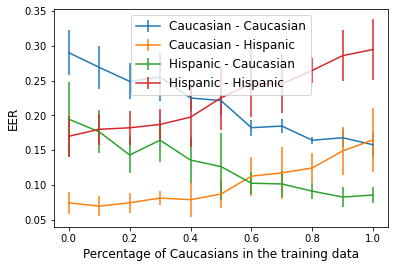

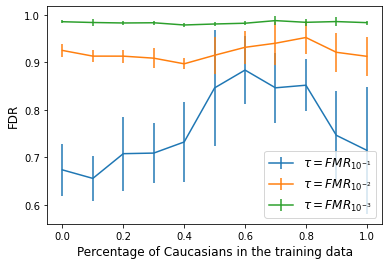

100%|██████████| 10/10 [03:25<00:00, 20.58s/it]


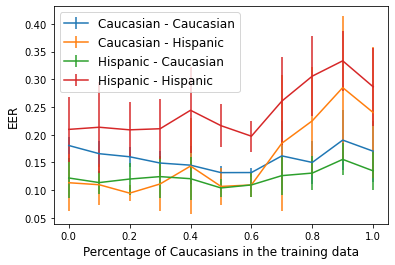

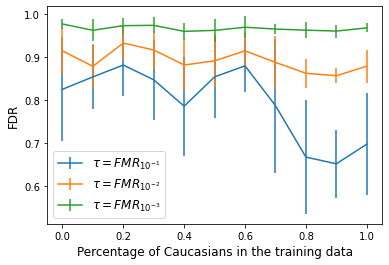

100%|██████████| 10/10 [03:26<00:00, 20.66s/it]


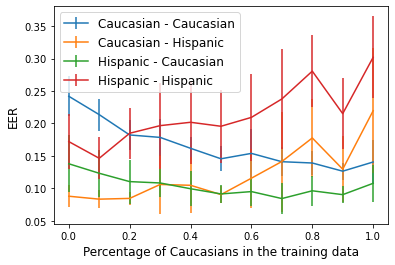

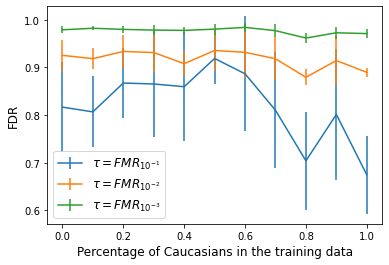

100%|██████████| 10/10 [03:34<00:00, 21.49s/it]


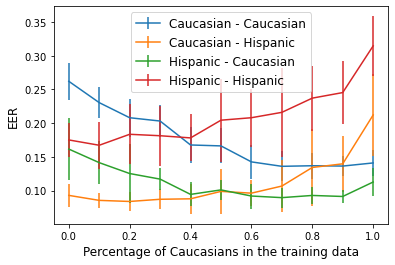

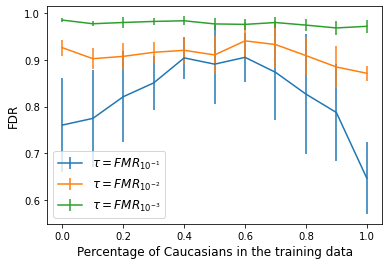

In [32]:
train_distributions = np.arange(0,1.1,0.1)
stimuli_lists = [   ['TEX'],
                    ['BLG'],
                    ['FXS'],
                    ['HSS'],
                    ['RAN'],
                    ['VD1,VD2']]
for stimuli in stimuli_lists:
    per_ethnicity_metric_dict = dict()
    per_ethnicity_fdr_metric_dict = dict()
    per_ethnicity_fdr_dict = dict()
    for train_percentage in tqdm(train_distributions):
        cur_percentage_str = '[' + str(np.round(train_percentage,decimals=1)) +\
                            ', ' + str(np.round(1.0 - train_percentage,decimals=1)) + ']'
        metric_dict = plotting_utils.get_metric_dict_for_setting(inspect_key = 'normalized Ethnicity',
                                inspect_list = ['Caucasian','Hispanic'],
                                window_size =  10,
                                num_folds = 10,
                                use_trial_types = stimuli,
                                used_train_key = "Self-Identified_Ethnicity_list_['White',_'Hispanic']",
                                used_train_percentage = cur_percentage_str,
                                used_train_seconds_per_user = 80,
                                data_dir = 'saved_score_dicts/',
                                demo_dict = demo_dict)
        if len(metric_dict) > 0:
            per_ethnicity_metric_dict[train_percentage] = metric_dict
            fdr_metric_dict, fdr_dict = plotting_utils.get_fdr_metric_dict(metric_dict,
                                inspect_thresholds = inspect_thresholds,
                                plot_points = 5000)
            per_ethnicity_fdr_metric_dict[train_percentage] = fdr_metric_dict
            per_ethnicity_fdr_dict[train_percentage] = fdr_dict

    plotting_utils.plot_eer_percentage(per_ethnicity_fdr_metric_dict,
                            x_label = 'Percentage of Caucasians in the training data',
                            y_label = 'EER',
                            font_size = 12)
    plt.savefig('plots/eer_ethnicty_deepeye_' +\
                    str(stimuli) + '.pdf')
    plt.show()
    plotting_utils.plot_fdr_percentage(per_ethnicity_fdr_dict,
                            inspect_thresholds = [0.1,0.01,0.001],
                            x_label = 'Percentage of Caucasians in the training data',
                            y_label = 'FDR',
                            font_size = 12)
    plt.savefig('plots/fdr_ethnicty_deepeye_' +\
                    str(stimuli) + '.pdf')
    plt.show()

### FDR_AUC plot over percentage

In [ ]:
train_distributions = np.arange(0,1.1,0.1)
per_ethnicity_all_metric_dict = dict()
per_ethnicity_all_fdr_metric_dict = dict()
per_ethnicity_all_fdr_dict = dict()
use_tasks = ['TEX','BLG','FXS','HSS','RAN','VD1,VD2']
fdr_auc_dicts = dict()
for i in tqdm(np.arange(len(use_tasks))):
    cur_task = use_tasks[i]
    fdr_auc_dicts[cur_task] = dict()
    for train_distribution in train_distributions:
        cur_percentage_str = '[' + str(np.round(train_distribution,decimals=1)) +\
                            ', ' + str(np.round(1.0 - train_distribution,decimals=1)) + ']'
        train_distribution = np.round(train_distribution,decimals=1)
        metric_dict = plotting_utils.get_metric_dict_for_setting(inspect_key = 'normalized Ethnicity',
                                inspect_list = ['Caucasian','Hispanic'],
                                window_size =  10,
                                num_folds = 10,
                                use_trial_types = [cur_task],
                                used_train_key = "Self-Identified_Ethnicity_list_['White',_'Hispanic']",
                                used_train_percentage = cur_percentage_str,
                                used_train_seconds_per_user = 80,
                                data_dir = 'saved_score_dicts/',
                                demo_dict = demo_dict,
                                model = 'deepeye',
                                only_equal = True)
        if len(metric_dict) > 0:            
            fdr_aucs = plotting_utils.compute_fdr_aucs(metric_dict, cur_task, cur_task)
            fdr_auc_dicts[cur_task][train_distribution] = fdr_aucs

TEX
    0.0: |*
    0.1: |
    0.2: |
    0.3: |
    0.4: |
    0.5: *|
    0.6: *|
    0.7: |
    0.8: |
    0.9: |*
    1.0: |*
BLG
    0.0: |
    0.1: |
    0.2: |
    0.3: |
    0.4: |
    0.5: |
    0.6: |
    0.7: |
    0.8: |
    0.9: |
    1.0: |*
FXS
    0.0: |*
    0.1: |*
    0.2: |*
    0.3: |*
    0.4: |*
    0.5: |
    0.6: |
    0.7: |
    0.8: |
    0.9: |
    1.0: |
HSS
    0.0: |
    0.1: |
    0.2: |
    0.3: |
    0.4: |
    0.5: |
    0.6: |
    0.7: |
    0.8: |*
    0.9: |*
    1.0: |*
RAN
    0.0: |*
    0.1: |*
    0.2: |
    0.3: |
    0.4: |
    0.5: |
    0.6: |
    0.7: |*
    0.8: |*
    0.9: |
    1.0: |*
VD1,VD2
    0.0: |
    0.1: |*
    0.2: |
    0.3: |
    0.4: |
    0.5: |
    0.6: |
    0.7: |
    0.8: |
    0.9: |
    1.0: |*


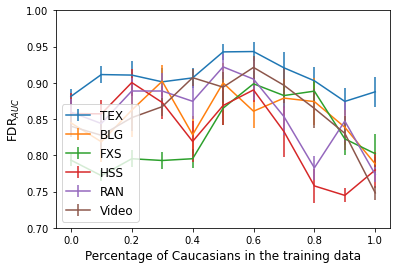

In [39]:
plotting_utils.plot_fdr_auc(fdr_auc_dicts,
                    x_label = 'Percentage of Caucasians in the training data',
                    y_label = 'FDR$_{AUC}$',
                    font_size = 12)
plt.savefig('plots/fdr_auc_deepeye.pdf')
plt.show()